# Описание задачи

Компания "Работа с заботой" хочет оптимизировать управление персоналом. Нам как аналитикам были предоставлены данные о сотрудниках компании.  С помощью тестирования была собрана информация об удовлетворенности сотрудников компанией, по результатам тестирования считается доля удовлетворенности, где 0 - не удовлетворен, 1 - полностью удовлетворен. Нужно создать модель машинного обучения, которая будет предсказывать уровень удовлетворенности сотрудника компанией. Кроме того, нужно создать модель, которая будет прогнозировать уход сотрудника из компании. 

In [197]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
import shap
from sklearn.linear_model import (
    LogisticRegression, 
    LinearRegression
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import (
    make_scorer,
    r2_score,
    RocCurveDisplay, 
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.neighbors import ( 
    KNeighborsRegressor,
    KNeighborsClassifier
)
from optuna.integration import OptunaSearchCV
from optuna.distributions import ( 
    IntDistribution, 
    CategoricalDistribution,
    FloatDistribution
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import phik

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE=42

# Задача регрессии

Начнём с предсказания удовлетворенности сотрудников рабочим местом, чтобы это сделать создадим модели регрессии для предсказания признака.

# Предобработка данных

In [198]:
df_train = pd.read_csv('train_job_satisfaction_rate.csv')

In [199]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [200]:
df_test = pd.read_csv('test_features.csv')

In [201]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [202]:
test_target = pd.read_csv('test_target_job_satisfaction_rate.csv')

In [203]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


## train_job_satisfaction_rate

In [204]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [205]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Как видим, все типы данных соответствуют заявленным, посмотрим пропуски в данных.

In [206]:
df_train[df_train.isna().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Имеются пропуски в столбцах dept и level, заполним их самым частыми значениями в этих столбцах с помощью пайплайна при подготовке данных. Посмотрим дубликаты - так как у нас может быть 2 одинаковых по характеристикам сотрудника, выведем только дубликаты только в столбце id, чтобы один сотрудник не попался дважды.

In [207]:
df_train[df_train['id'].duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Как видим, таких нет. Посмотрим, что в категориальных столбцах верно, указаны все названия.

In [208]:
for column in df_train.select_dtypes(exclude='number').columns:
    print(column, df_train[column].unique())

dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'high' 'low']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Неявных дубликатов в этих строках нет, всё хорошо.

## test_features

Проведём здесь такой же обзор.

In [209]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [210]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [211]:
df_test[df_test.isnull().any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Так же удалим при подготовке данных.

In [212]:
df_test[df_test['id'].duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


In [213]:
for column in df_test.select_dtypes(exclude='number').columns:
    print(column, df_test[column].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' ' ']
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


Здесь появились пустые строки, заменим их на NaN.

In [214]:
df_test['dept'] = df_test['dept'].replace({' ': np.nan})
df_test['workload'] = df_test['workload'].replace({' ': np.nan})

In [215]:
for column in df_test.select_dtypes(exclude='number').columns:
    print(column, df_test[column].unique())

dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level ['junior' 'middle' 'sinior' nan]
workload ['medium' 'low' 'high' nan]
last_year_promo ['no' 'yes']
last_year_violations ['no' 'yes']


## Выводы

Данные были изучены - типы данных соответсвуют заявленным, в данных имеются пропуски, они будут удалены при подготовке.

# Исследовательский анализ данных

## train_job_satisfaction_rate

In [216]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


### Количественные признаки

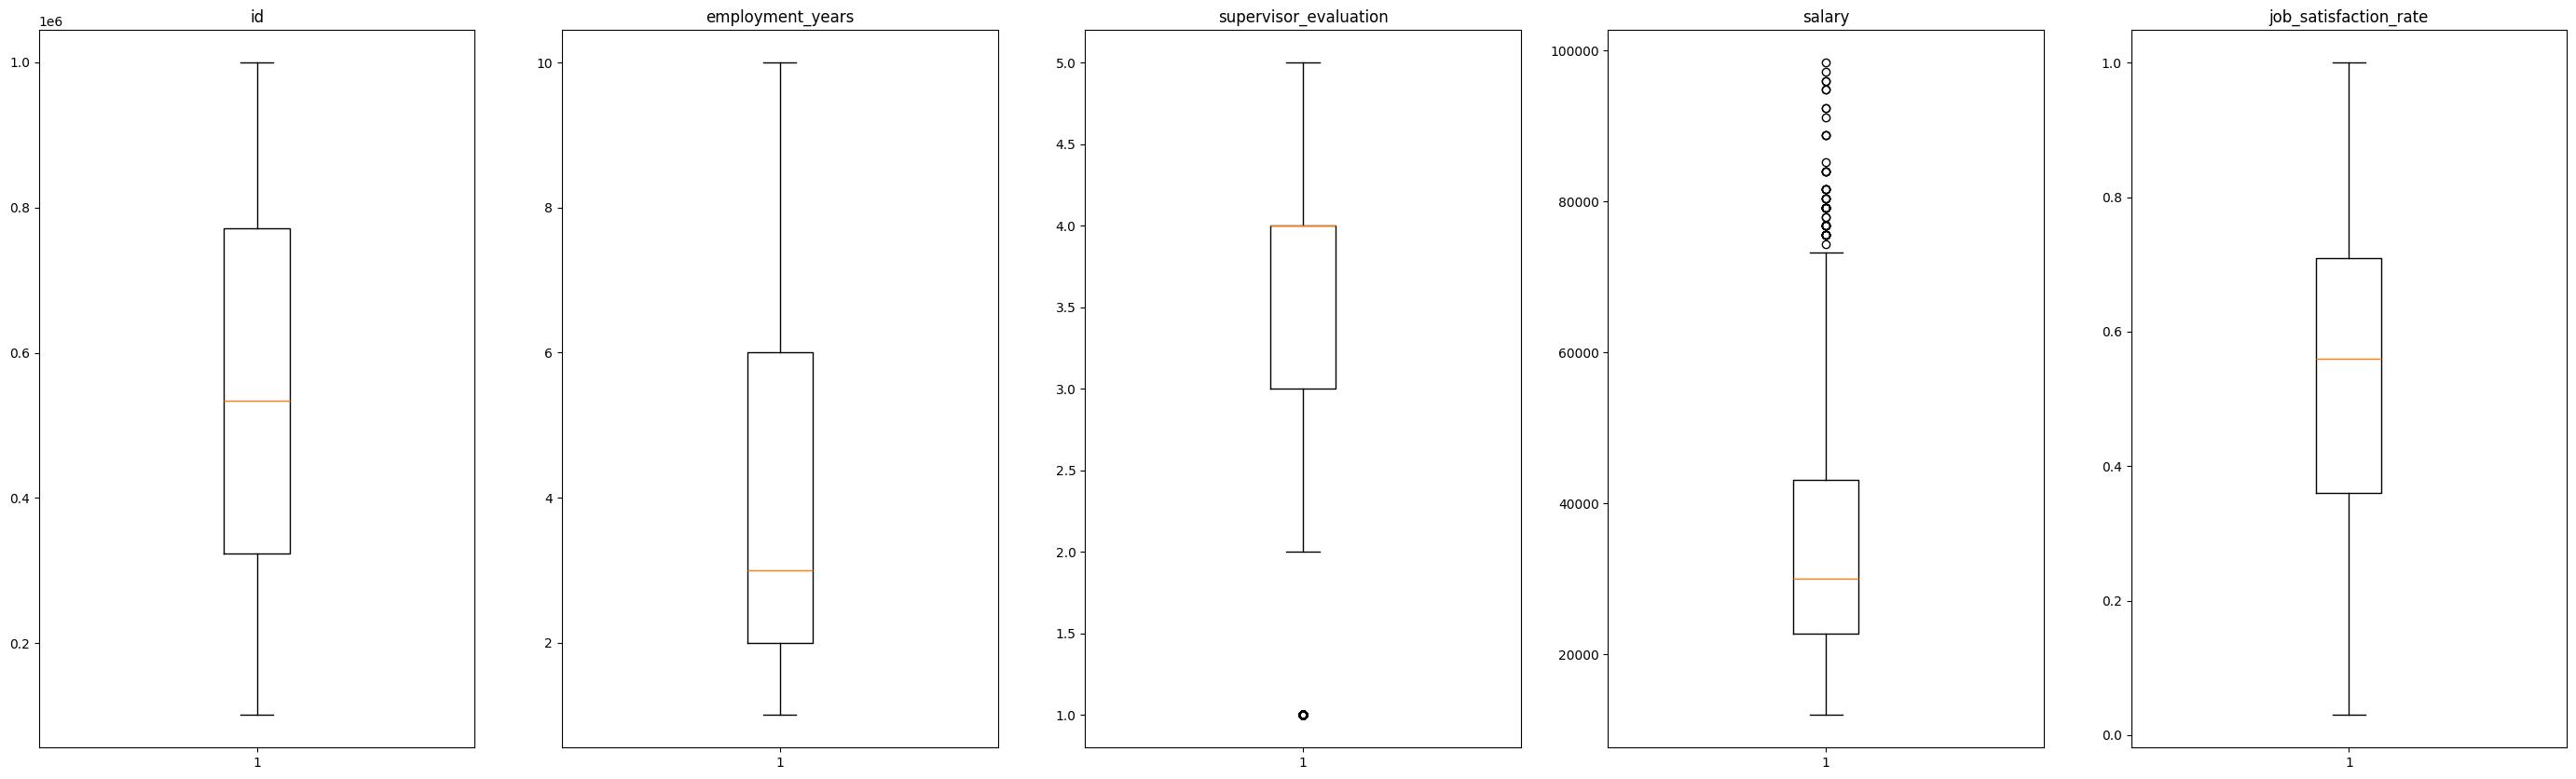

In [217]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(include='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(include='number').columns):
    axs[i].boxplot(df_train.loc[:, name])
    axs[i].set_title(name)

plt.show()

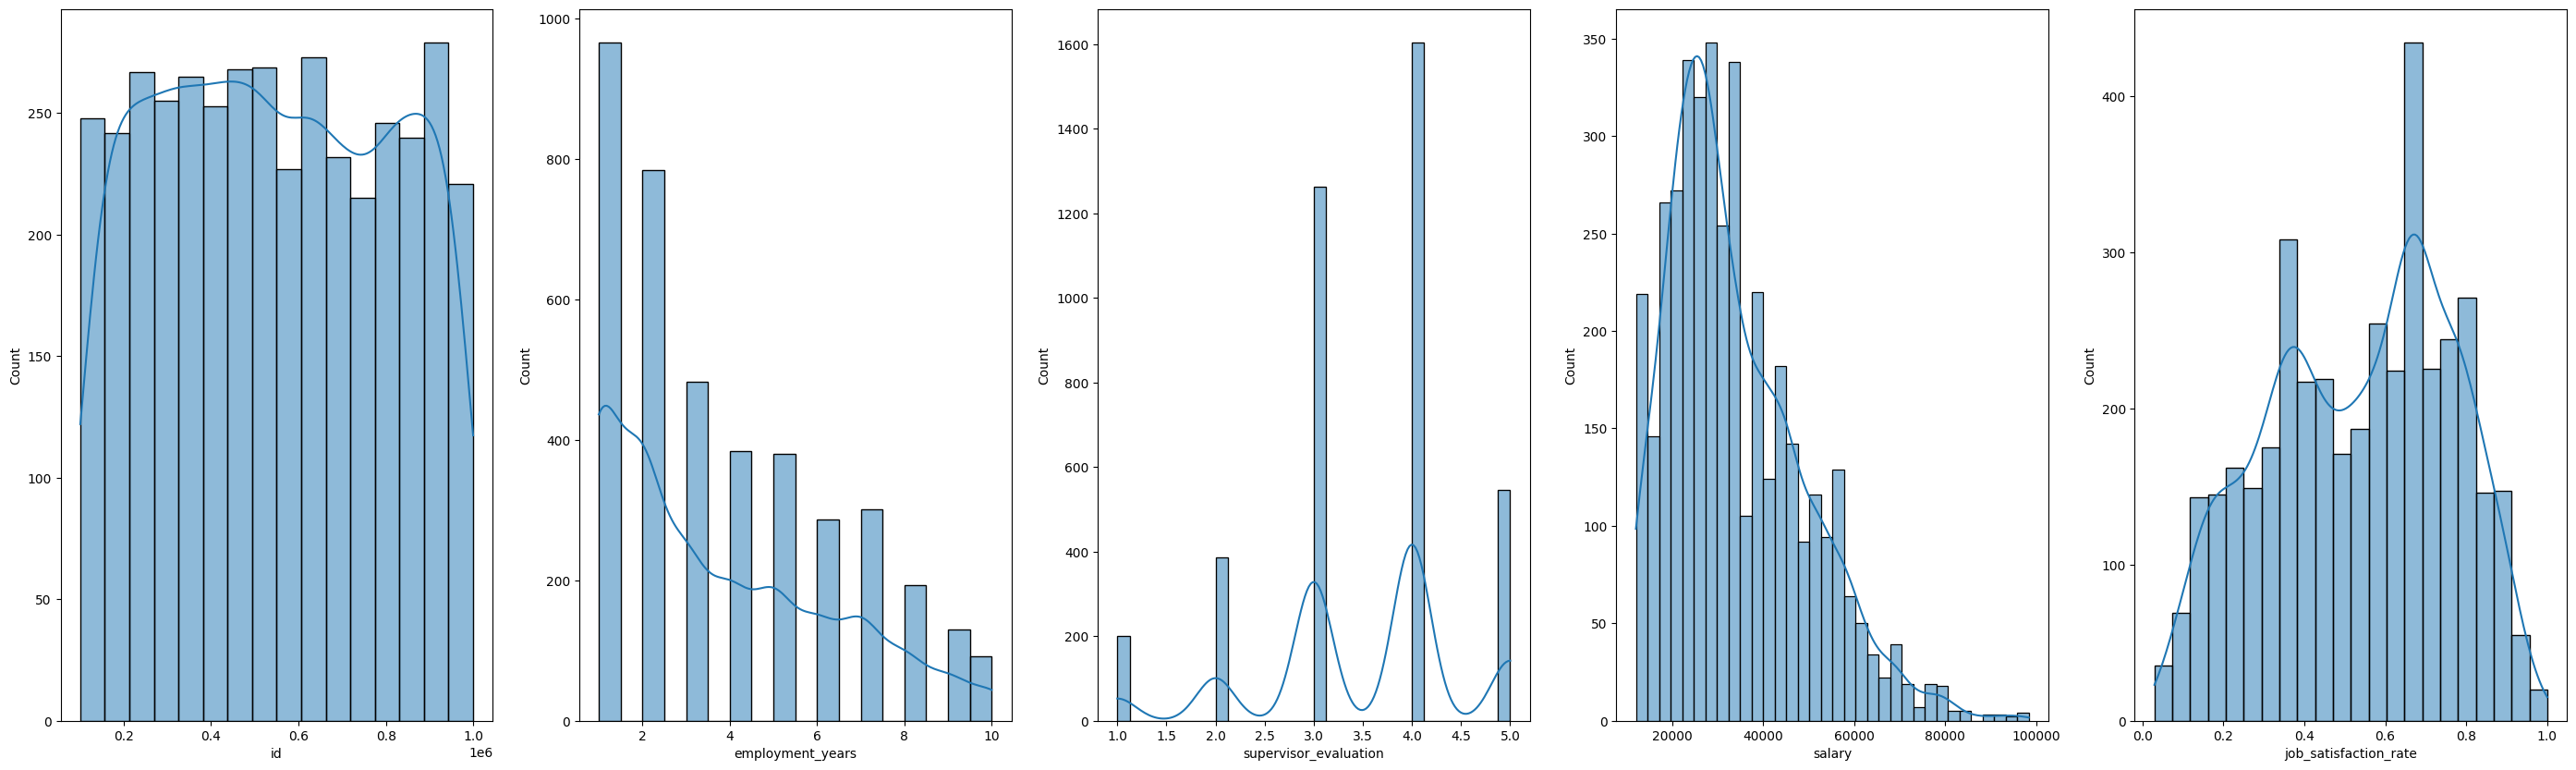

In [218]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(include='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(include='number').columns):
    sns.histplot(data=df_train.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel(name)

plt.show()

In [219]:
for i, name in enumerate(df_train.select_dtypes(include='number').columns):
    print(df_train.loc[:, name].describe())

count      4000.000000
mean     544957.621000
std      257883.104622
min      100954.000000
25%      322836.750000
50%      534082.500000
75%      771446.000000
max      999521.000000
Name: id, dtype: float64
count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64
count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64
count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64
count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000

Видим следующее:

employement_years - Убывающее распределение с медианой примерно равно 3. Возможно, среднестатистический сотрудник долго не задерживается в компании и через 2-3 года уходит из компании, а может, компания только 2-3 года назад начала активно набирать сотрудников из-за чего их количество резко выросло. Не можем однозначно судить о средней продолжительности жизни сотрудника в компании, но можем говорить, что сотрудников со сроком работы от года до трёх больше, чем остальных.

supervisor_evaluation - Большинству сотрудников руководитель даёт оценки 3-4. Допускаем, что оценка руководителя объективная, значит, большинство выполнет работу на удовлитворительный уровень и не более. Меньшинство справляется очень плохо или очень хорошо. 

salary - медианная зарплата 30 000 у.е. распределение зарплат сосредоточено около этого числа.

job_satisfaction_rate - уровень удовлетворенности работой большей частью лежит в промежутке от 0.36 до 0.71, значит, далеко не все сотрудники полностью удовлетворены работой.

### Категориальные признаки

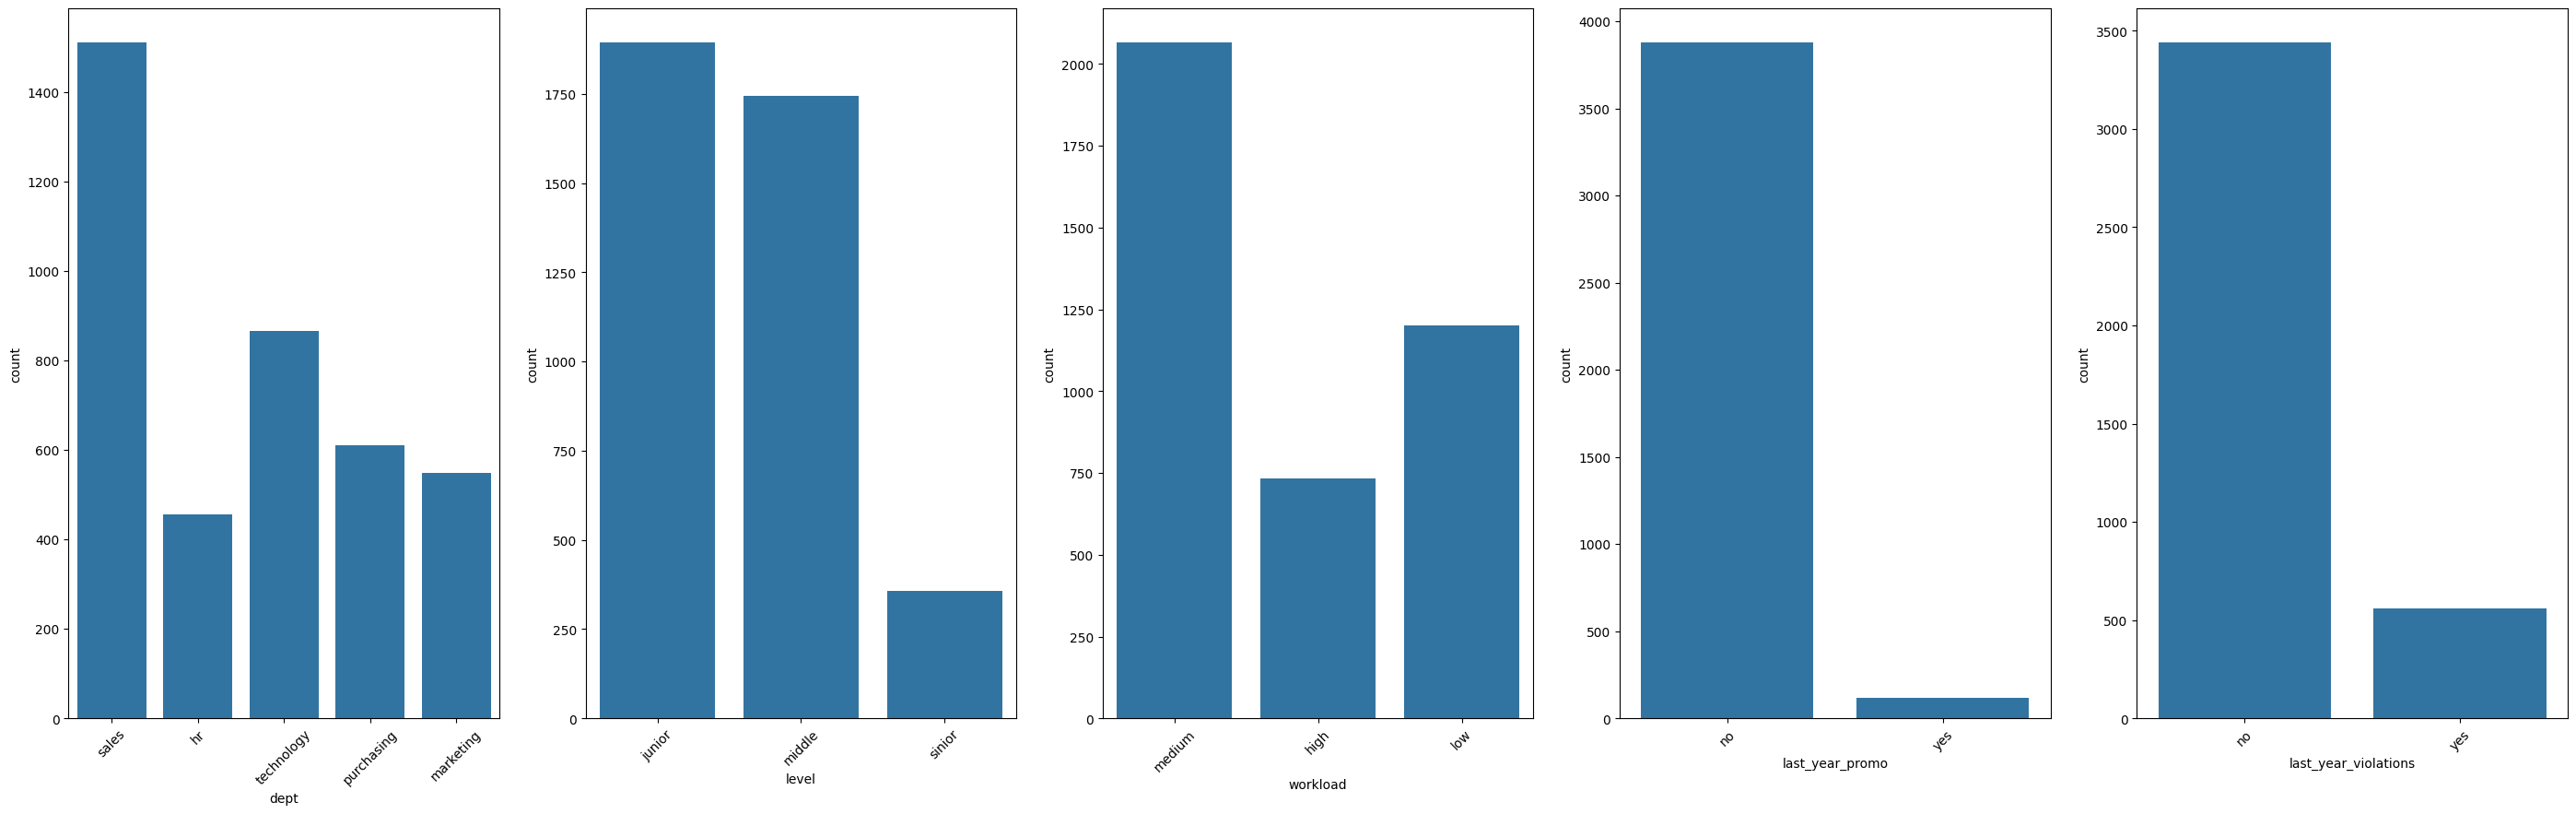

In [220]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(exclude='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(exclude='number').columns):
    sns.countplot(data=df_train, x=name, ax=axs[i])
    axs[i].set_xlabel(name)
    axs[i].tick_params(axis='x', rotation=45)

plt.show()

Большинство сотрудников работают в отделе продаж, за ним идут технический отдел, отдел закупок, маркетинг и замыкает hr отдел. 

По позициям имеет, что почти все сотрудники компании это junior и middle и оставшаяся малая часть sinor.

Видно, что за год было совсем мало повышений, компания, вероятно, не даёт быстрого карьерного роста.

По поводу выговоров - их тоже немного относительно общего количества.

## test_features

In [221]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


### Количественные признаки

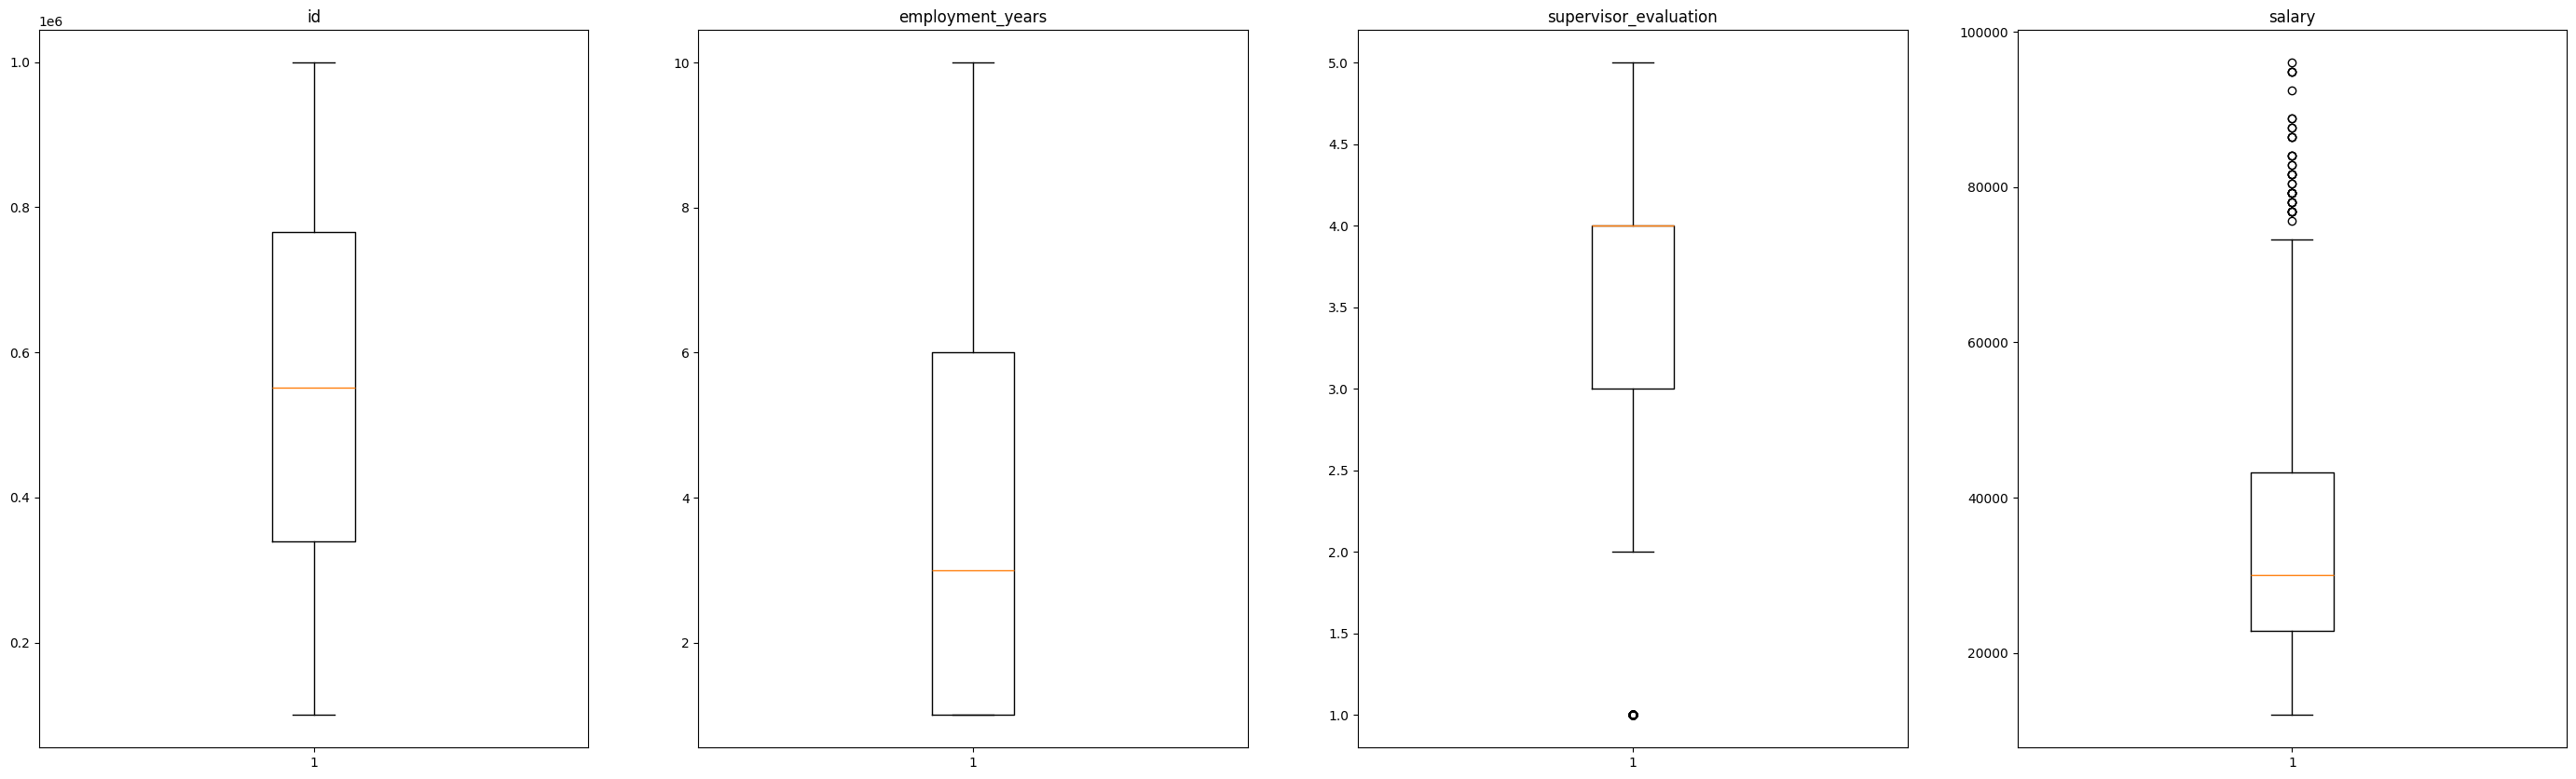

In [222]:
fig, axs = plt.subplots(nrows=1, ncols=df_test.select_dtypes(include='number').shape[1], figsize=(35, 10))

for i, name in enumerate(df_test.select_dtypes(include='number').columns):
    axs[i].boxplot(df_test.select_dtypes(include='number').loc[:, name])
    axs[i].set_title(name)

plt.show()

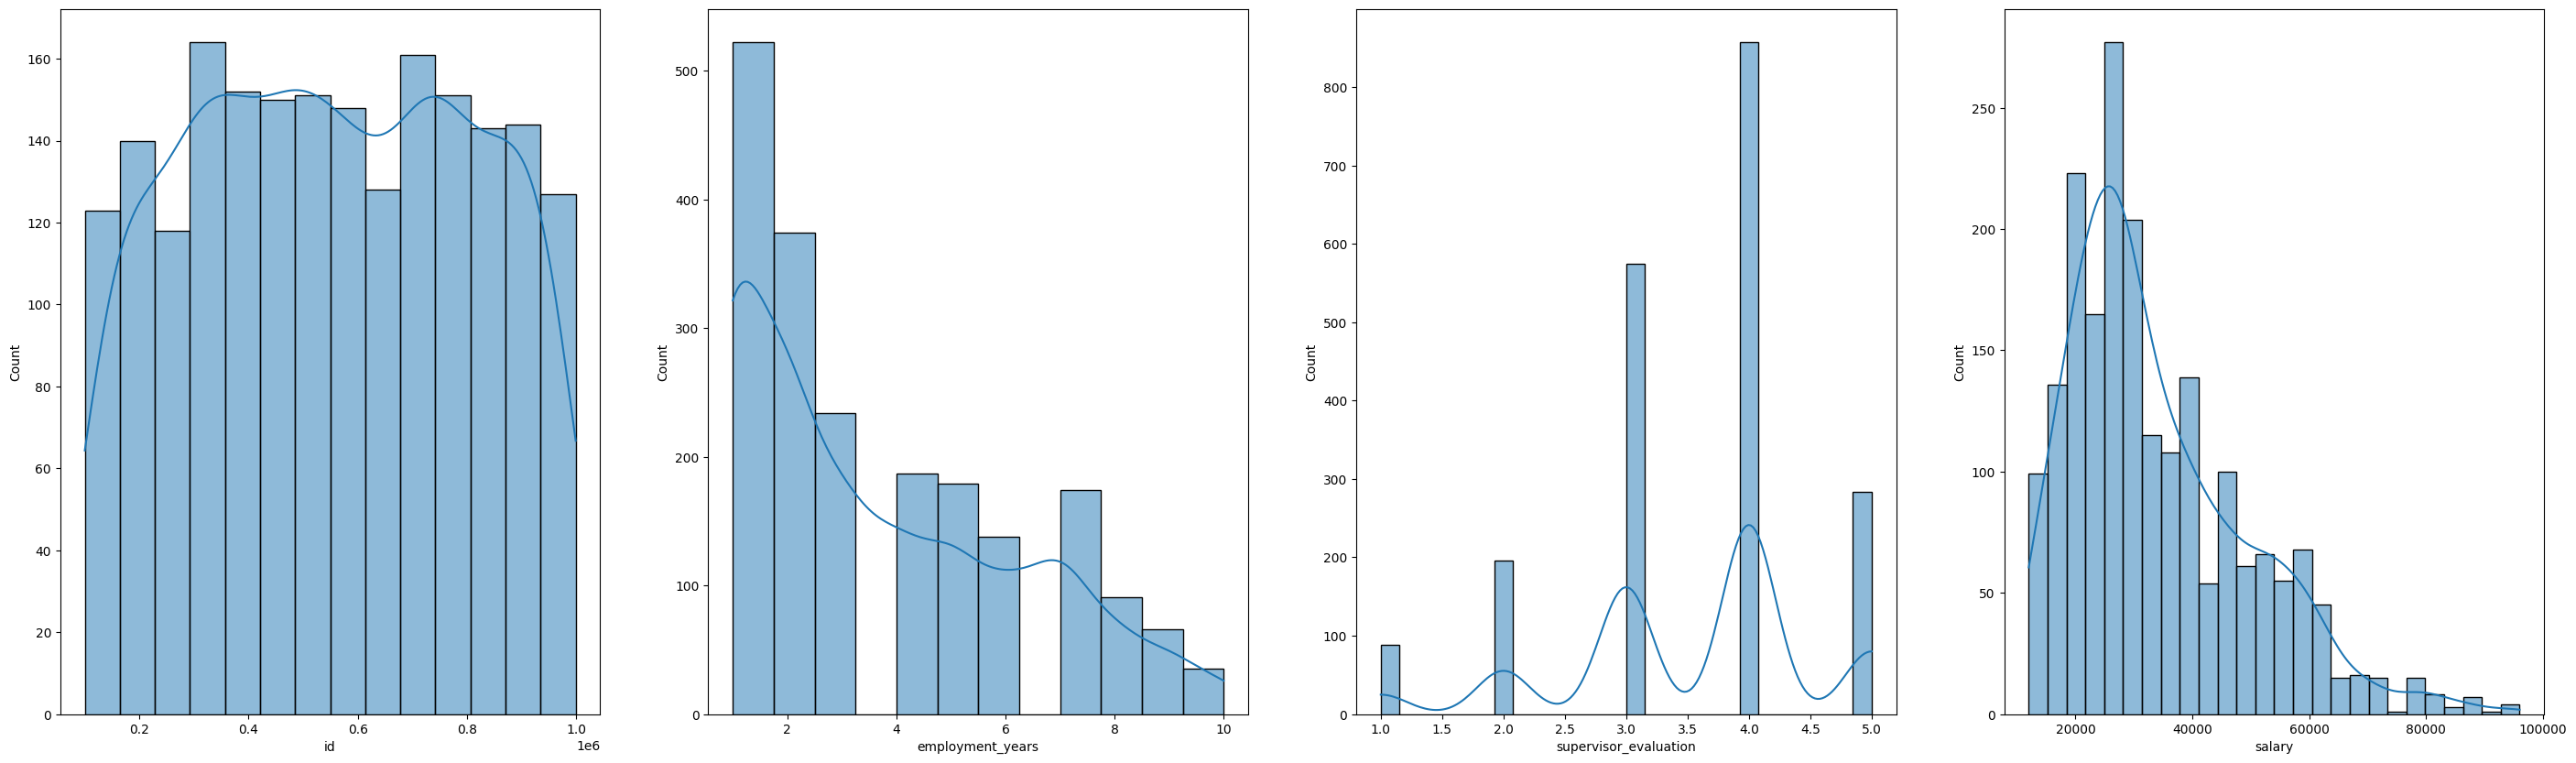

In [223]:
fig, axs = plt.subplots(nrows=1, ncols=df_test.select_dtypes(include='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_test.select_dtypes(include='number').columns):
    sns.histplot(data=df_test.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel(name)

plt.show()

Распределение тестовых данных совпадает с тренировочной выборкой.

### Категориальные признаки

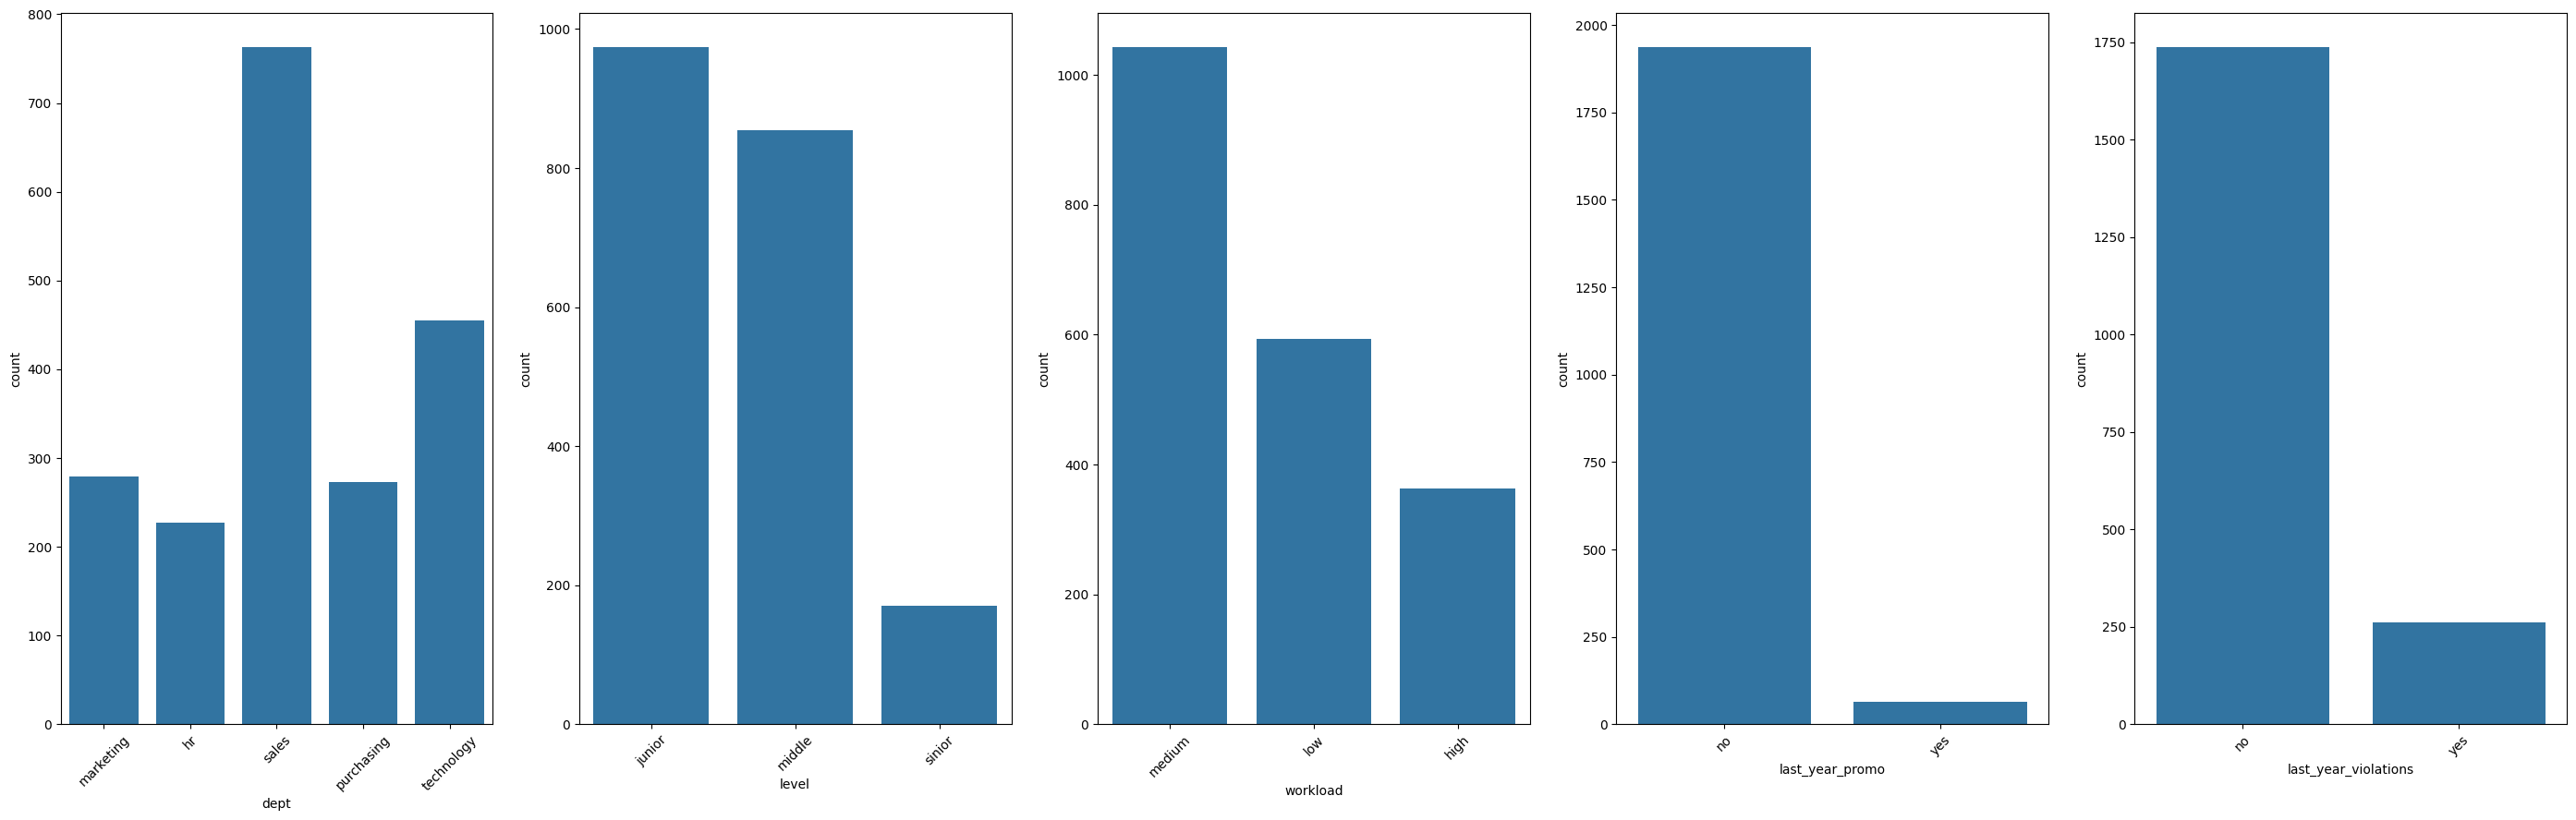

In [224]:
fig, axs = plt.subplots(nrows=1, ncols=df_test.select_dtypes(exclude='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_test.select_dtypes(exclude='number').columns):
    sns.countplot(data=df_test, x=name, ax=axs[i])
    axs[i].set_xlabel(name)
    axs[i].tick_params(axis='x', rotation=45)

plt.show()

Опять же видим схожесть данных.

## test_target

In [225]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


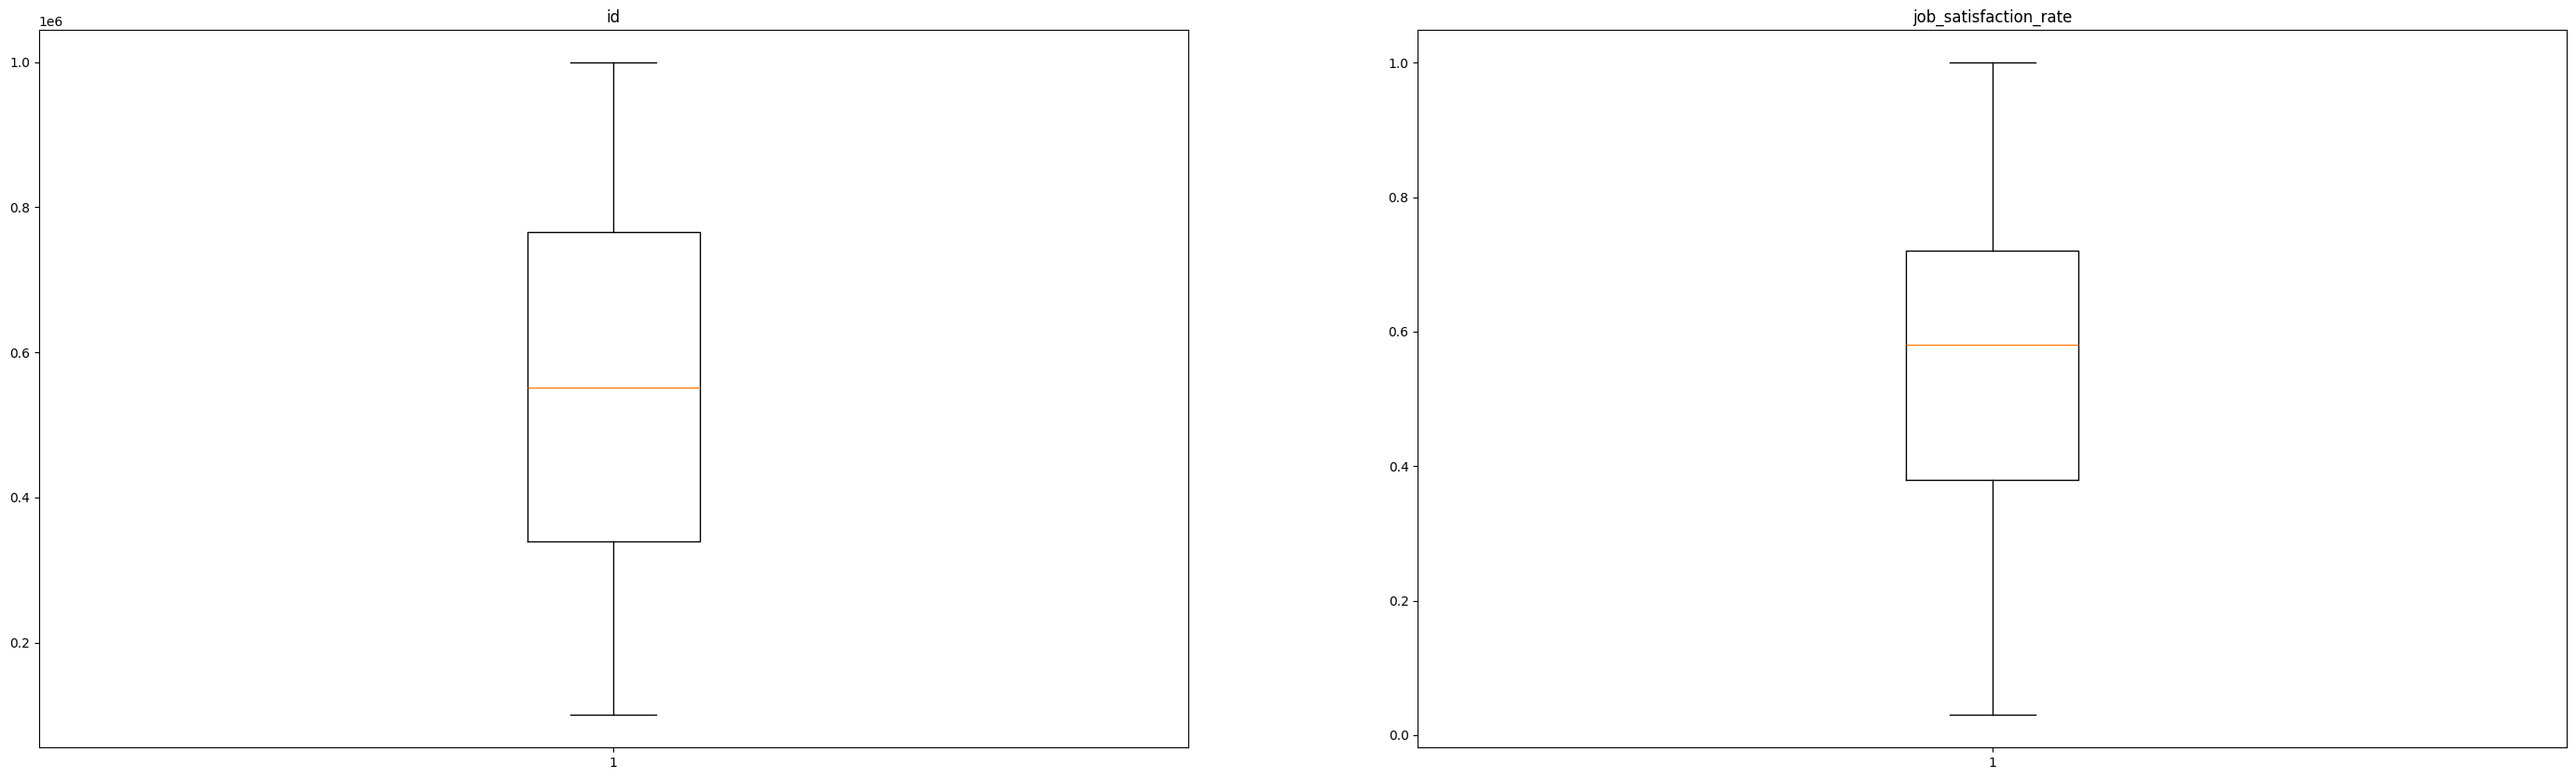

In [226]:
fig, axs = plt.subplots(nrows=1, ncols=test_target.select_dtypes(include='number').shape[1], figsize=(35, 10))

for i, name in enumerate(test_target.select_dtypes(include='number').columns):
    axs[i].boxplot(test_target.select_dtypes(include='number').loc[:, name])
    axs[i].set_title(name)

plt.show()

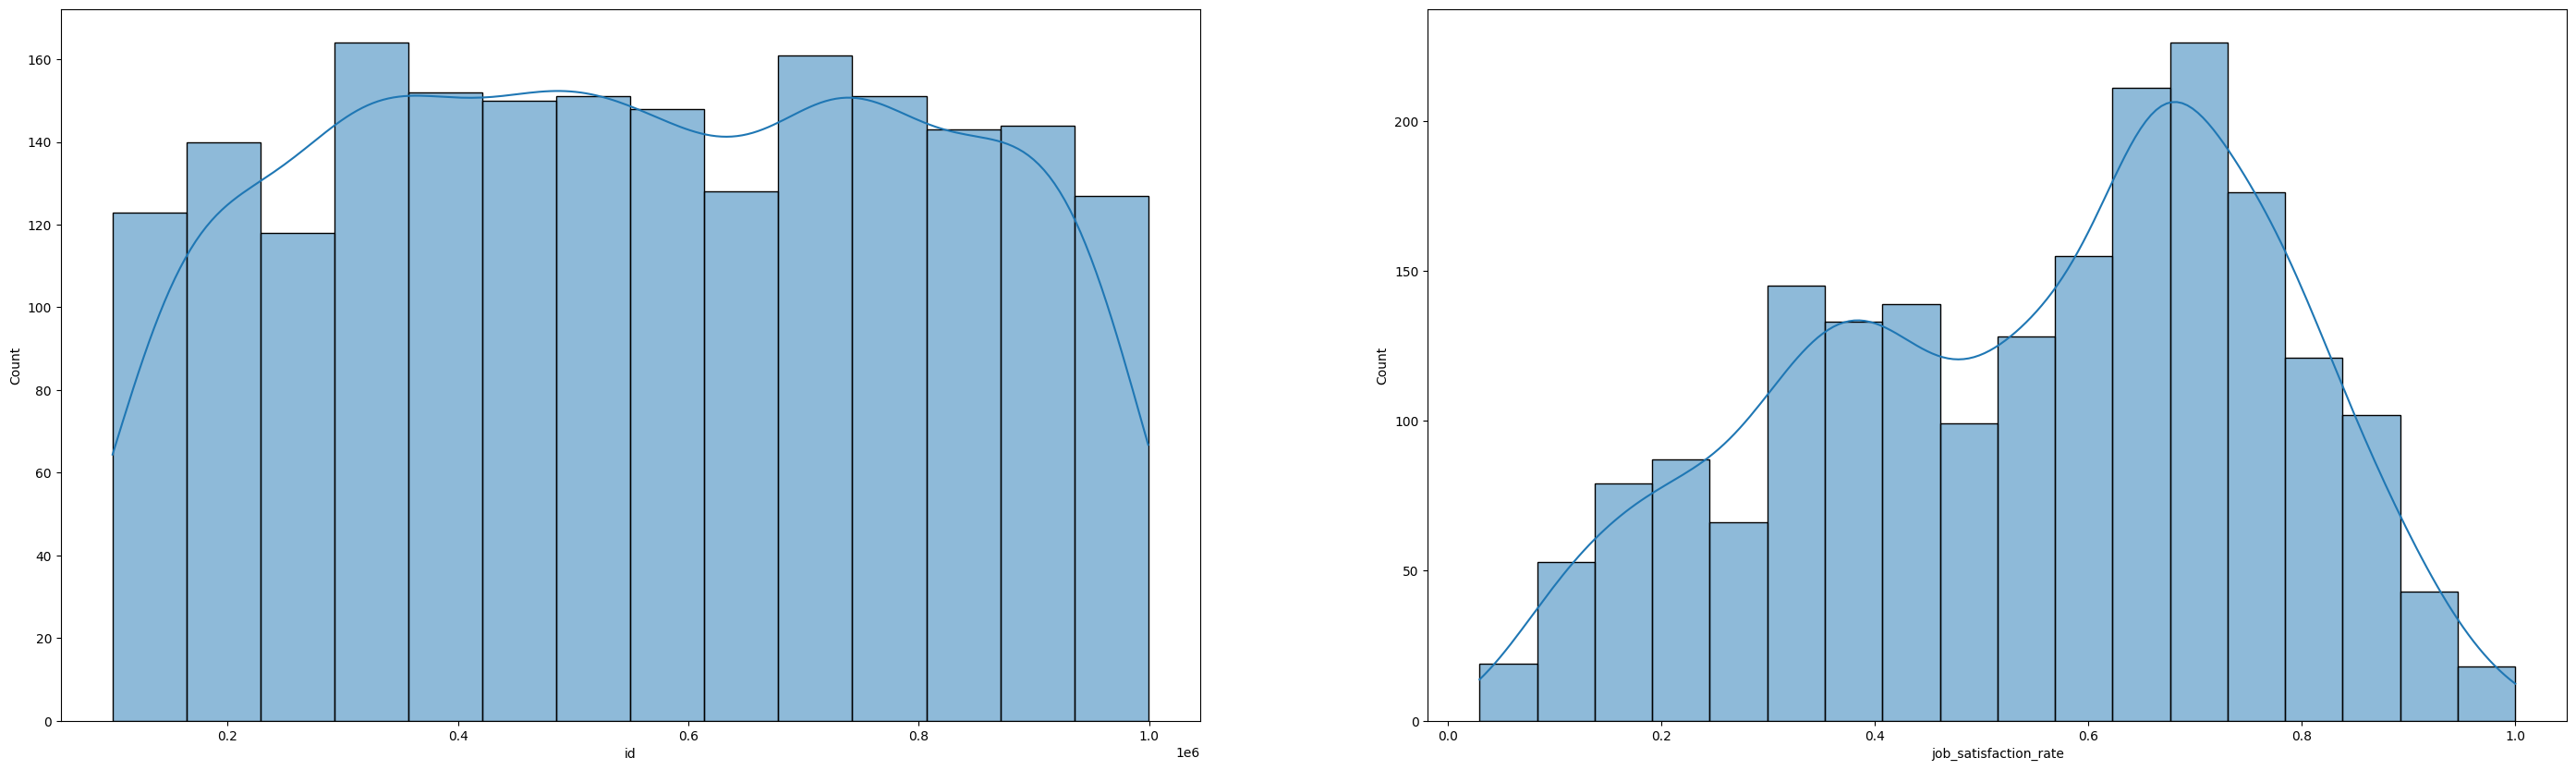

In [227]:
fig, axs = plt.subplots(nrows=1, ncols=test_target.select_dtypes(include='number').shape[1], figsize=(35,10))

for i, name in enumerate(test_target.select_dtypes(include='number').columns):
    sns.histplot(data=test_target.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel(name)

plt.show()

Опять же видим, что данные похожи на тренировочную выборку.

## Корреляционный анализ

In [228]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Перед построением матрицы корреляции проверим на нормальное распределение признаки.

In [229]:
for column in df_train.select_dtypes(include='number'):
    stat, p_val = shapiro(df_train[column])
    if p_val < 0.05: 
        print('не нормальное')
    else:
        print('нормальное')

не нормальное
не нормальное
не нормальное
не нормальное
не нормальное


Так как признаки распределены не нормально, будем пользоваться корреляцией Спирмэна. 

In [230]:
correlation_matrix = df_train.select_dtypes(include='number').corr(method='spearman')
correlation_matrix

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
id,1.000000,-0.014145,-0.000649,-0.016749,0.004812
employment_years,-0.014145,1.000000,-0.001554,0.472688,0.218589
supervisor_evaluation,-0.000649,-0.001554,1.000000,0.003534,0.746608
salary,-0.016749,0.472688,0.003534,1.000000,0.126707
job_satisfaction_rate,0.004812,0.218589,0.746608,0.126707,1.000000


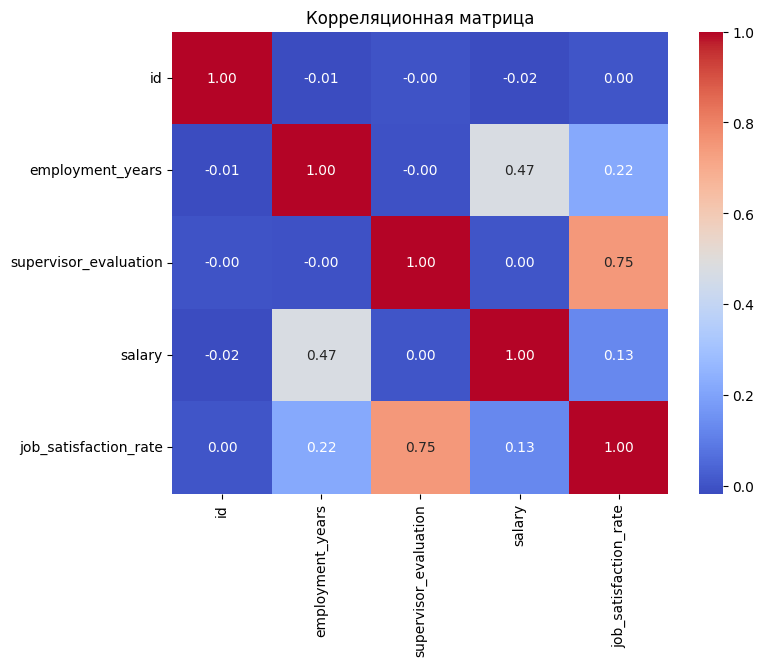

In [231]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

На целевой больше всех влияет оценка работника работодателем, за ним идёт длителньость работы в компании, потом зарплата и замыкает список id, который вовсе не влияет на целевой. Посмотрим с категориальными признаками.

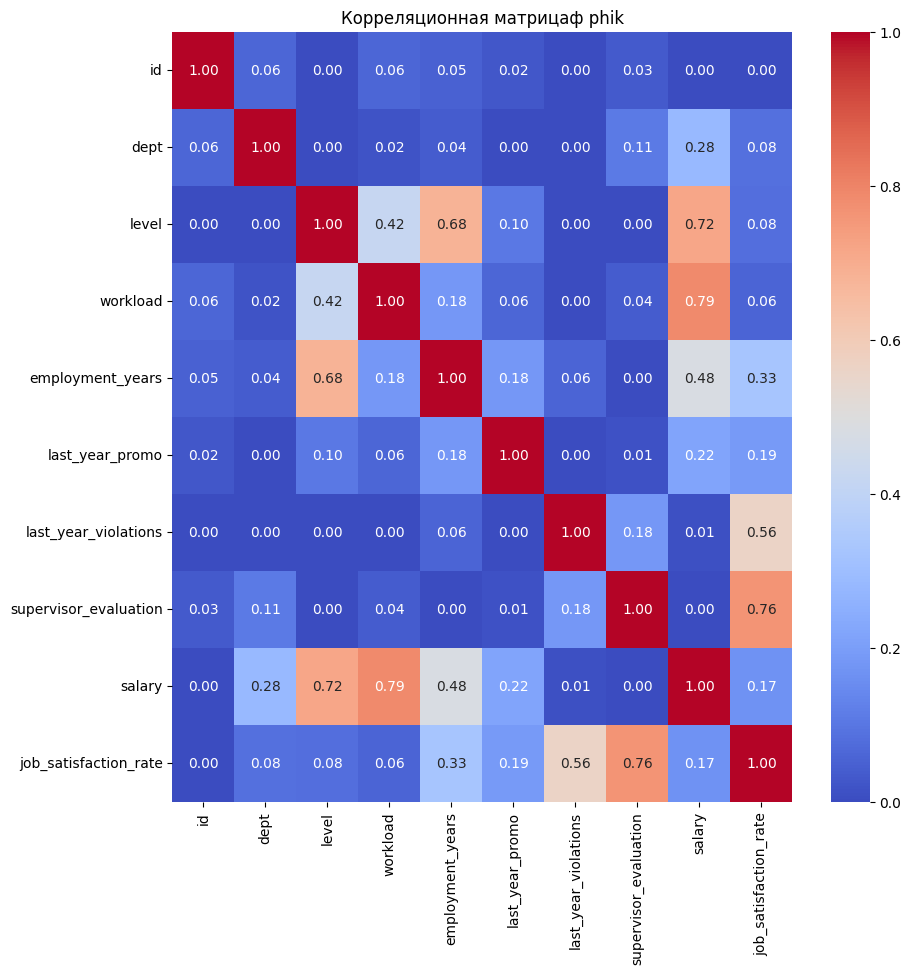

In [232]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.phik_matrix(interval_cols=df_train.select_dtypes(include='number')), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрицаф phik')
plt.show();

Между признаками имеется мультиколлинеарность в такой связке Зарплата - Позиция - Длительность работы в компании, логично, что, чем человек больше работает, тем выше должность и тем выше зарплата. Однако, максимальный коэффициент 0.79, что не критично, поэтому не будем пока убирать. 

## Вывод

Были исследованы данные, все данные соответствуют заявленным, тренировочная и тестовая выборка, присланные заказчиком похожи. Корреляционный анадиз показал, что на целевой не влияет только id, остальные имеют хоть некоторые и небольшое влияние. Между признаками имеется мультиколлинеарность в связке Зарплата - Позиция - Длительность работы, но она не критична, поэтому оставим.

# Подготовка данных

In [233]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Создадим пайплайны для предобработки данных. Будем кодировать с помощью OHE признак dept, так как он не порядковый, остальные с помощью OrdinalEncoder, так как они все порядковые. Кроме того, удалим признак id, так как он может испортить модель.

In [234]:
X = df_train.drop(['job_satisfaction_rate'], axis=1)
y = df_train['job_satisfaction_rate']

In [235]:
cat_ohe_columns = ['dept']
cat_ord_columns = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'id']

In [236]:
for name in cat_ord_columns:
    print(df_train[name].unique())

['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


In [237]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    ['no', 'yes'],
                    ['no', 'yes']
                ]
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_ohe_columns),
        ('ord', ord_pipe, cat_ord_columns),
        ('scaler', 'passthrough', num_columns)
    ], 
    remainder='passthrough'
)

pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('selector', SelectKBest()),
        ('model', None)
    ]
)

# Обучение моделей

Сначала создадим метрику.

In [238]:
def smape_score(y_true, y_pred, **kwargs):
    return ( 100 / len(y_true) ) * np.sum( np.abs(y_true - y_pred) / ( (np.abs(y_true) + np.abs(y_pred) ) / 2) )

smape = make_scorer(smape_score, greater_is_better=False)

## Линейная регрессия

Обучим модель линейной регрессии. Будем пользоваться StandardScaler, так как он лучше всего подходит для линейных моделей.

In [239]:
param_grid_linear = {
    'model': [LinearRegression()],
    'preprocessor__scaler': [StandardScaler()],
    'selector__k': range(1, len(X.columns)+1)
}

In [240]:
scoring_funcs = {
    'smape': smape,
    'r2': 'r2'
}

grid_linear = GridSearchCV(
    pipe,
    param_grid=param_grid_linear,
    cv=5,
    scoring=scoring_funcs,
    n_jobs=-1,
    refit='smape'
)

grid_linear.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          Simple...
                                                                         'passthrough',
                                                                         ['employment_years',
                                                                          'supervisor_evaluation',
                                                                          'salary',
                                                                          'id'])])),
                                       ('selector', SelectKBest()),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid={'model': [LinearRegression()],
                         'preprocessor__scaler': [StandardScaler()],
                         'selector__k': range(1, 10)},
             refit='smape',
             scoring={'r2': 'r2',
                      'smape': make_scorer(smape_score, greater_is_better=False, response_method='predict')})

In [241]:
results_linear = pd.DataFrame(grid_linear.cv_results_)
results_linear[['mean_fit_time', 'mean_test_smape', 'mean_test_r2', 'param_selector__k']].sort_values(by='mean_test_smape', ascending=False)

,mean_fit_time,mean_test_smape,mean_test_r2,param_selector__k
8,0.046599,-26.864956,0.633604,9
7,0.060813,-27.271204,0.624609,8
6,0.059206,-27.462858,0.617025,7
5,0.049194,-27.650176,0.607940,6
3,0.049199,-28.007045,0.591772,4
4,0.054208,-28.012417,0.591675,5
2,0.049200,-28.850609,0.547665,3
1,0.047999,-29.019819,0.534874,2
0,0.053196,-30.289372,0.476580,1


Модель вышла плохая, она плохо предсказывает данные, лучше попробовать поискать модель, которая получше найдёт закономерности.

## Дерево решений

Обучим модель дерева решений, масштабирование не будем использовать, так как дереву нет разницы сравнивать изначальные или "ужатые" величины.

In [242]:
param_grid_tree = {
    'model': CategoricalDistribution([DecisionTreeRegressor()]),
    'model__max_depth': IntDistribution(2, 15),
    'model__min_samples_leaf': IntDistribution(2, 15),
    'model__min_samples_split': IntDistribution(2, 15),
    'selector__k': IntDistribution(1, len(X.columns))
}

In [243]:
oscv_tree = OptunaSearchCV(
    pipe, 
    param_grid_tree, 
    cv=5, 
    scoring=smape, 
    n_trials=35, 
    random_state=RANDOM_STATE
)

In [244]:
oscv_tree.fit(X, y)

[I 2024-05-21 03:40:38,707] A new study created in memory with name: no-name-6990f055-a0f8-4dda-a97c-ac4e6eb414de
[I 2024-05-21 03:40:38,875] Trial 0 finished with value: -23.497150777434012 and parameters: {'model': DecisionTreeRegressor(max_depth=8, min_samples_leaf=13), 'model__max_depth': 8, 'model__min_samples_leaf': 13, 'model__min_samples_split': 2, 'selector__k': 3}. Best is trial 0 with value: -23.497150777434012.
[I 2024-05-21 03:40:39,042] Trial 1 finished with value: -23.769360699366306 and parameters: {'model': DecisionTreeRegressor(max_depth=8, min_samples_leaf=6, min_samples_split=4), 'model__max_depth': 8, 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'selector__k': 2}. Best is trial 0 with value: -23.497150777434012.
[I 2024-05-21 03:40:39,267] Trial 2 finished with value: -21.33710342389041 and parameters: {'model': DecisionTreeRegressor(max_depth=4, min_samples_leaf=6, min_samples_split=6), 'model__max_depth': 4, 'model__min_samples_leaf': 6, 'model__m

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['dept']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            Simp...
                                    'model__max_depth': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__min_samples_leaf': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__min_samples_split': IntDistribution(high=15, log=False, low=2, step=1),
                                    'selector__k': IntDistribution(high=9, log=False, low=1, step=1)},
               random_state=42,
               scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [245]:
results_tree = pd.DataFrame(oscv_tree.cv_results_)
print('Лучшие параметры')
oscv_tree.best_params_

Лучшие параметры


{'model': DecisionTreeRegressor(max_depth=13, min_samples_leaf=6, min_samples_split=4),
 'model__max_depth': 13,
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 5,
 'selector__k': 9}

In [246]:
print('Лучшая SMAPE:', oscv_tree.best_score_)

Лучшая SMAPE: -15.827536374682392


Эта модель отрабатывает гораздо лучше, её метрики выходят намного лучше. Попробуем ещё модели.

## kNN

Здесь тоже не будем использовать StandardScaler, так как kNN наоборот испортится из-за "сжатия" расстояний.

In [247]:
param_grid_knn = {
    'model': CategoricalDistribution([KNeighborsRegressor()]),
    'model__n_neighbors': IntDistribution(2, 15),
    'model__metric': CategoricalDistribution(['euclidean', 'minkowski']),
    'model__weights': CategoricalDistribution(['uniform', 'distance']),
    'selector__k': IntDistribution(1, len(X.columns))
}

In [248]:
oscv_knn = OptunaSearchCV(
    pipe, 
    param_grid_knn, 
    cv=5, 
    scoring=smape, 
    n_trials=35, 
    random_state=RANDOM_STATE
)

In [249]:
oscv_knn.fit(X, y)

[I 2024-05-21 03:40:46,535] A new study created in memory with name: no-name-38d4c321-d61d-4f22-92d1-00d3253f04f0
[I 2024-05-21 03:40:46,751] Trial 0 finished with value: -24.352032173961852 and parameters: {'model': KNeighborsRegressor(metric='euclidean', n_neighbors=8, weights='distance'), 'model__n_neighbors': 8, 'model__metric': 'euclidean', 'model__weights': 'distance', 'selector__k': 3}. Best is trial 0 with value: -24.352032173961852.
[I 2024-05-21 03:40:47,019] Trial 1 finished with value: -24.06656213825484 and parameters: {'model': KNeighborsRegressor(n_neighbors=4, weights='distance'), 'model__n_neighbors': 4, 'model__metric': 'minkowski', 'model__weights': 'distance', 'selector__k': 9}. Best is trial 1 with value: -24.06656213825484.
[I 2024-05-21 03:40:47,245] Trial 2 finished with value: -24.393345758078926 and parameters: {'model': KNeighborsRegressor(n_neighbors=9, weights='distance'), 'model__n_neighbors': 9, 'model__metric': 'minkowski', 'model__weights': 'distance', 

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['dept']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            Simp...
                                    'model__metric': CategoricalDistribution(choices=('euclidean', 'minkowski')),
                                    'model__n_neighbors': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__weights': CategoricalDistribution(choices=('uniform', 'distance')),
                                    'selector__k': IntDistribution(high=9, log=False, low=1, step=1)},
               random_state=42,
               scoring=make_scorer(smape_score, greater_is_better=False, response_method='predict'))

In [250]:
results_knn = pd.DataFrame(oscv_knn.cv_results_)
print('Лучшие параметры')
oscv_knn.best_params_

Лучшие параметры


{'model': KNeighborsRegressor(n_neighbors=14, weights='distance'),
 'model__n_neighbors': 14,
 'model__metric': 'euclidean',
 'model__weights': 'distance',
 'selector__k': 4}

In [251]:
print('Лучшая SMAPE:', oscv_knn.best_score_)

Лучшая SMAPE: -21.757159420719493


## Вывод

Лучшей моделью возьмём дерево решений, оно показало лучшую метрику SMAPE. Линейная регрессия вовсе не справилась с задачей, вероятно, данные плохо подчинаются линейному распределению. kNN тоже справилась неплохо, но показала метрики хуже, чем дерево решений. Дерево решений - лучшая из использованных моделей, продолжим исследования с ней. Посмотрим метрики данной модели на тестовой выбокре.

In [252]:
df_test = df_test.merge(test_target, on='id')

In [253]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [254]:
X_test = df_test.drop('job_satisfaction_rate', axis=1)
y_test = df_test['job_satisfaction_rate']

In [255]:
print('SMAPE:', smape_score(oscv_tree.predict(X_test), y_test))
print('R2:', r2_score(oscv_tree.predict(X_test), y_test))

SMAPE: 14.384464706324252
R2: 0.8599650115172406


In [256]:
oscv_tree.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequ...
                                                                                              ['no',
                                                                                               'yes']])),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload',
                                                   'last_year_promo',
                                                   'last_year_violations']),
                                                 ('scaler', 'passthrough',
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary', 'id'])])),
                ('selector', SelectKBest(k=9)),
                ('model',
                 DecisionTreeRegressor(max_depth=13, min_samples_leaf=6,
                                       min_samples_split=5))])

Метрики получились хорошие, данной моделью можно пользоваться для предсказаний. ( Посмотрим влияющие признаки - я не очень понимаю, как вывести топ признаков shap после SelectKBest и пайплайнов, там все названия пропадают, не могли бы вы помочь ).

# Классификация

Перейдём к задаче классификации, нам нужно предсказать увольнение сотрудника компании. Будем работать с обновленными данными.

# Предобработка данных

In [257]:
df_train = pd.read_csv('train_quit.csv')
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [258]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [259]:
test_target = pd.read_csv('test_target_quit.csv')
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## Пропуски

In [260]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [261]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Типы данных соответствуют заявленным, пропуски отсутствуют.

## Дубликаты

In [262]:
df_train[df_train['id'].duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


In [263]:
test_target[test_target['id'].duplicated()]

,id,quit


Дубликаты и пропуски отсутствуют.

# Исследовательский анализ данных

## Просмотр данных

In [264]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [265]:
test_target.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Посмотрим количественные и категориальные признаки в тренировочной выборке.

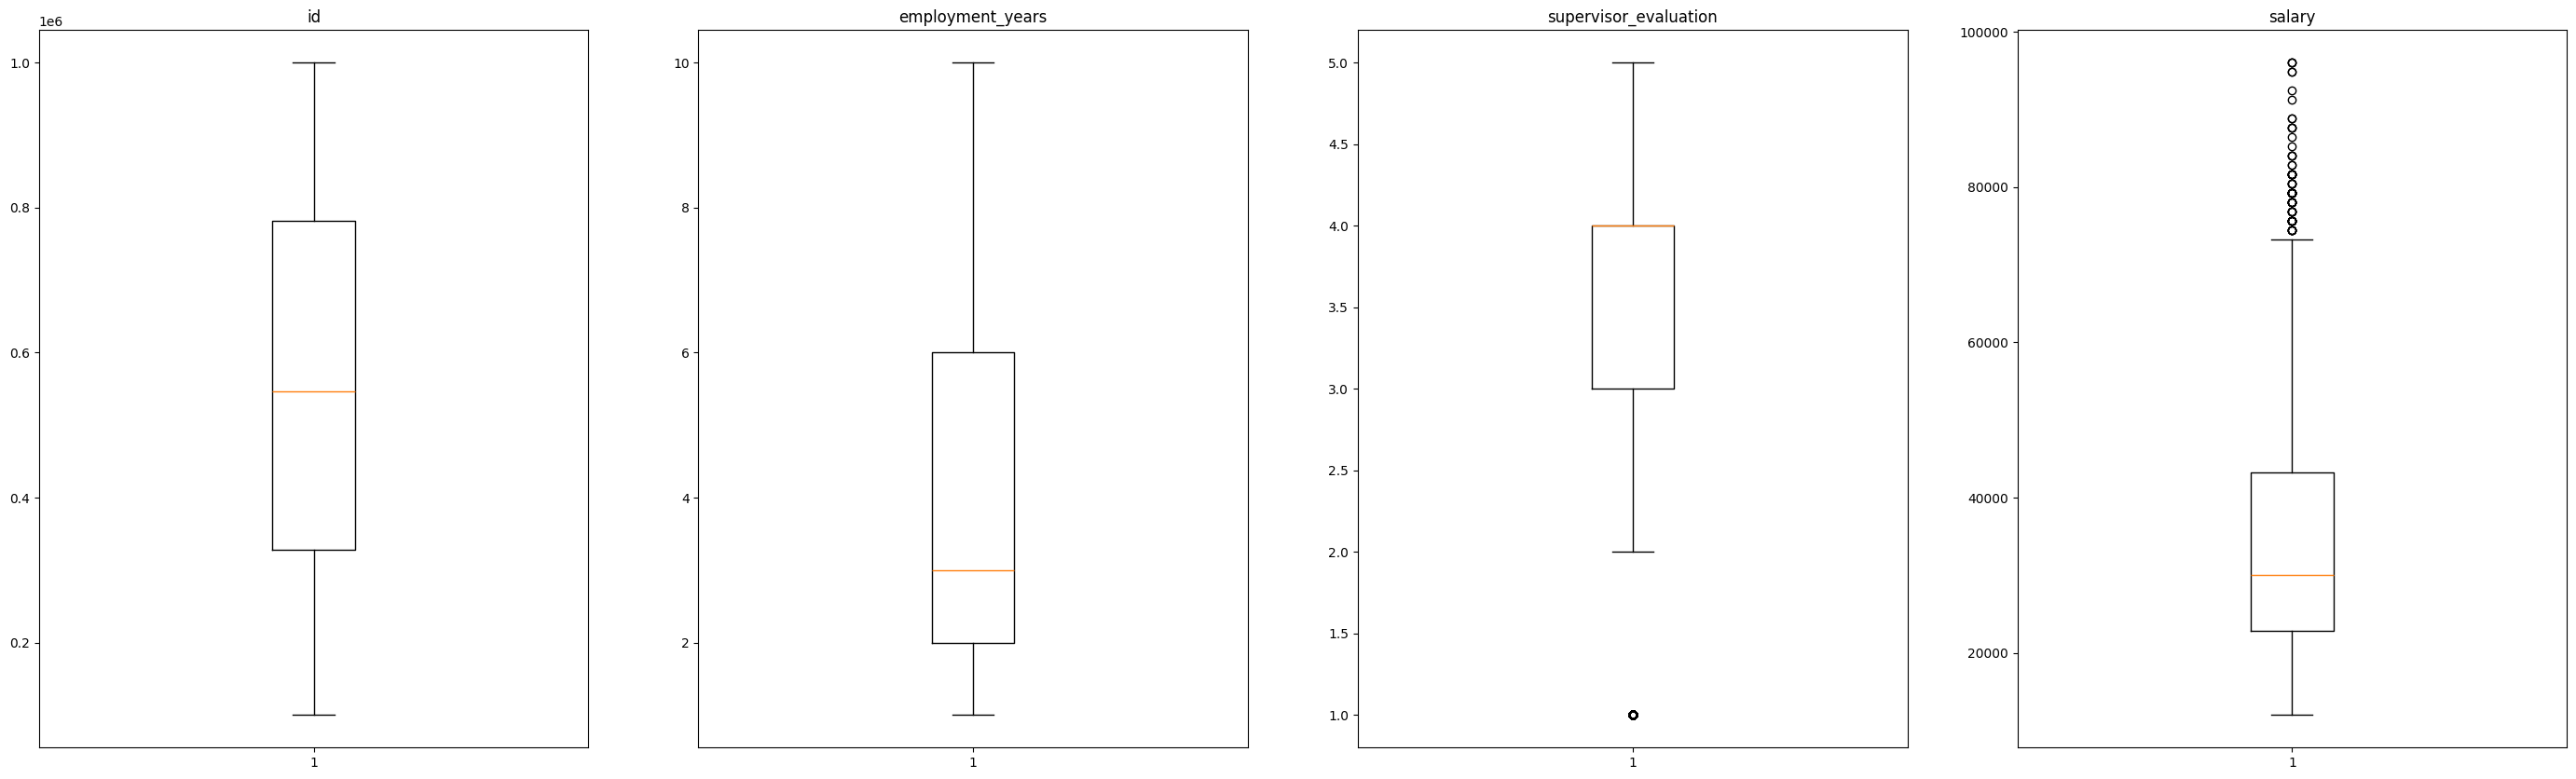

In [266]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(include='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(include='number').columns):
    axs[i].boxplot(df_train.loc[:, name])
    axs[i].set_title(name)

plt.show()

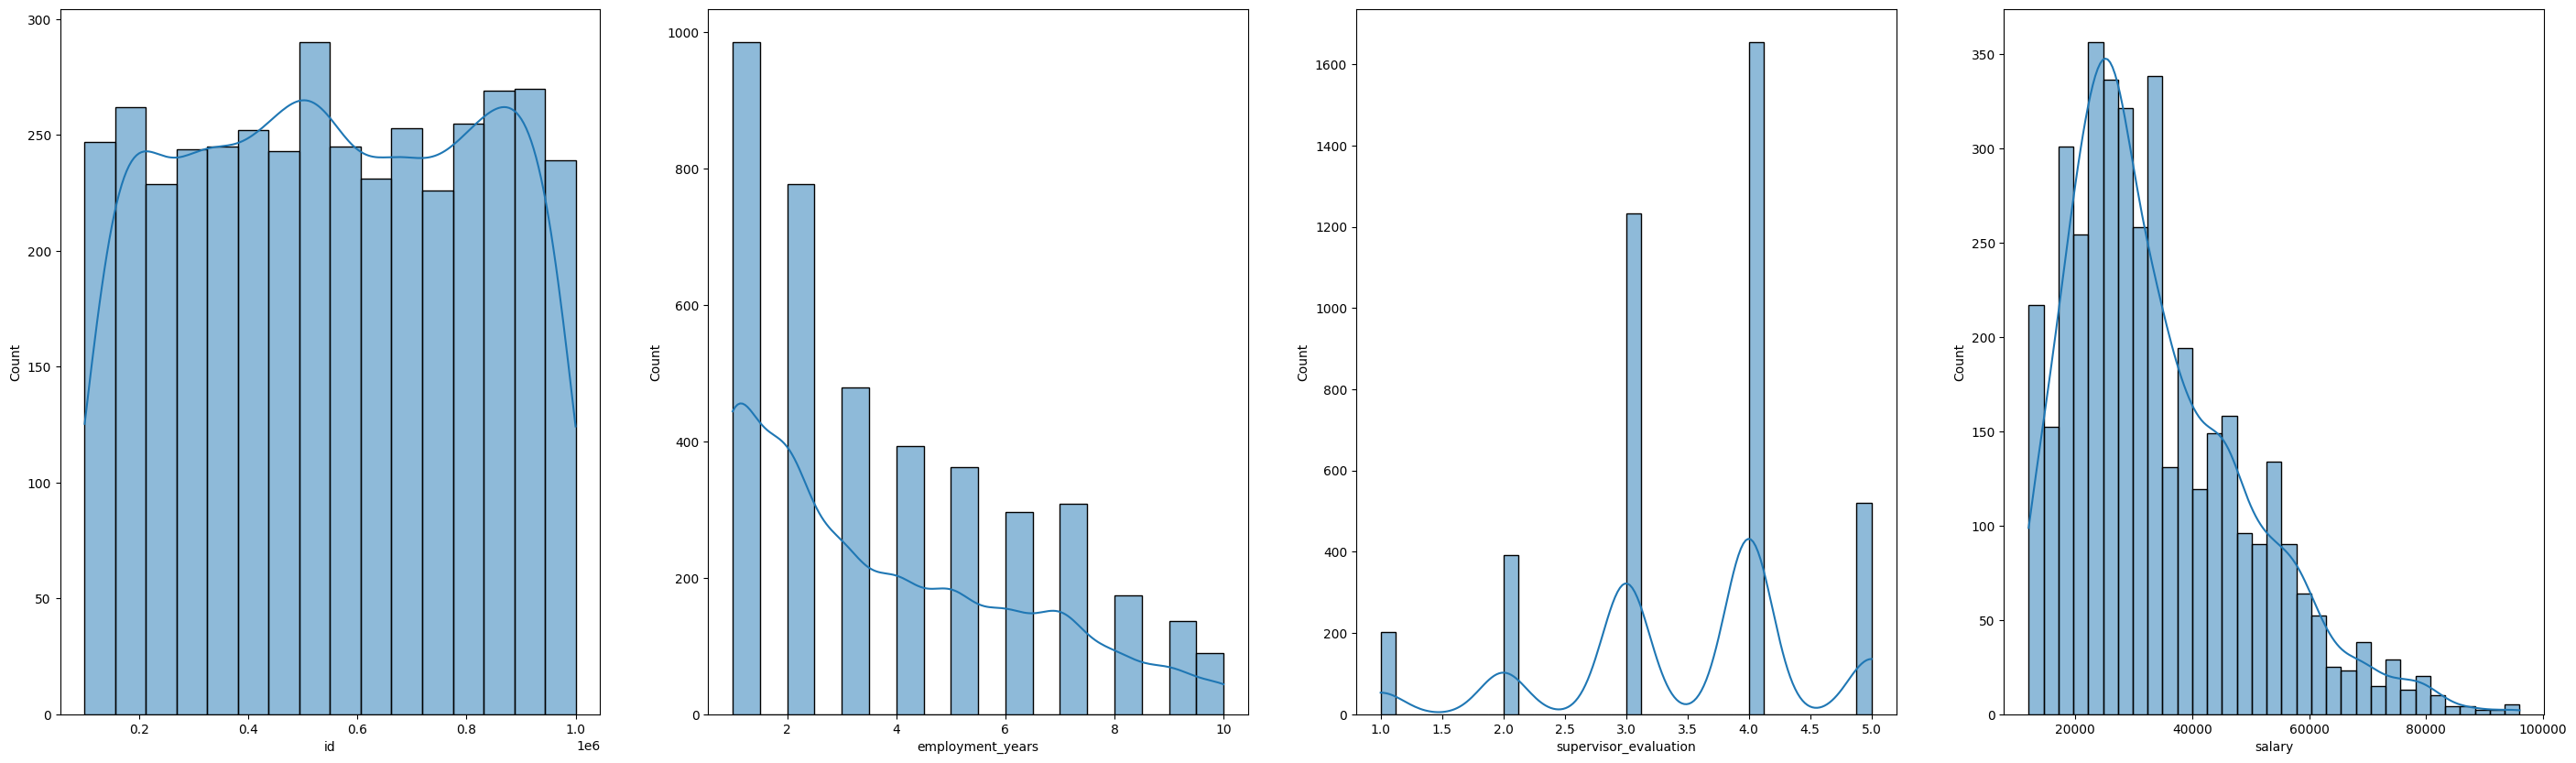

In [267]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(include='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(include='number').columns):
    sns.histplot(data=df_train.loc[:, name], ax=axs[i], kde=True)
    axs[i].set_xlabel(name)

plt.show()

Распределение данных такое же, как в предыдущей тренировочной выборке, что логично.

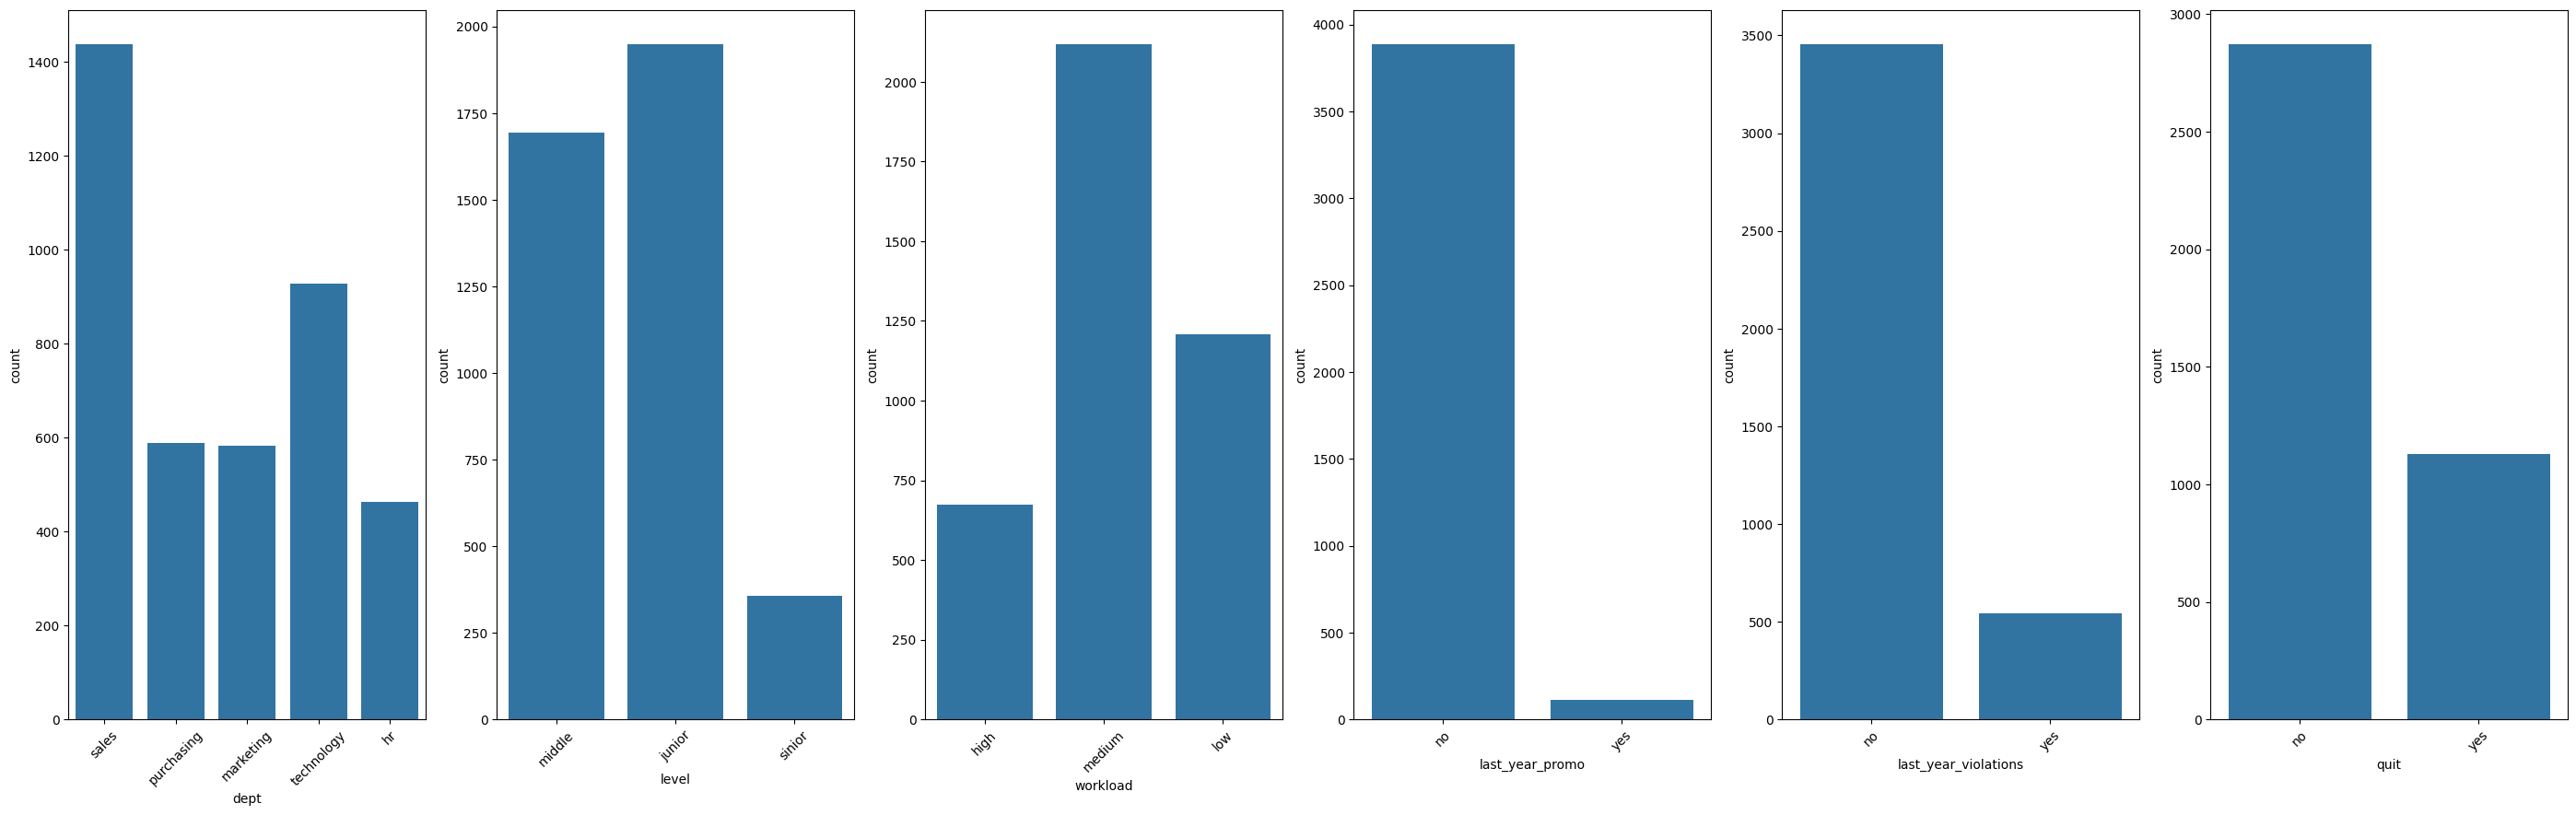

In [268]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(exclude='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(exclude='number').columns):
    sns.countplot(data=df_train, x=name, ax=axs[i])
    axs[i].set_xlabel(name)
    axs[i].tick_params(axis='x', rotation=45)

plt.show()

Опять всё примерно то же. По поводу целевого - видим дисбаланс классов, уходит меньше людей, чем остаётся, посмотрим точное количество.

In [269]:
df_train['quit'].value_counts()

quit
no     2872
yes    1128
Name: count, dtype: int64

Соотношение немного меньше, чем 1/3, в целом, это не критично, поэтому оставим как есть. Посмотрим распределение классов в тестовой выборке.

In [270]:
test_target['quit'].value_counts()

quit
no     1436
yes     564
Name: count, dtype: int64

Имеем похожее соотношение.

## Портрет уволившегося сотрудника

Сделаем такой же исследовательский анализ, но выделим уволившихся в последствии сотрудников. Вместе будем выводить всех оставшихся сотрудников для сравнения.

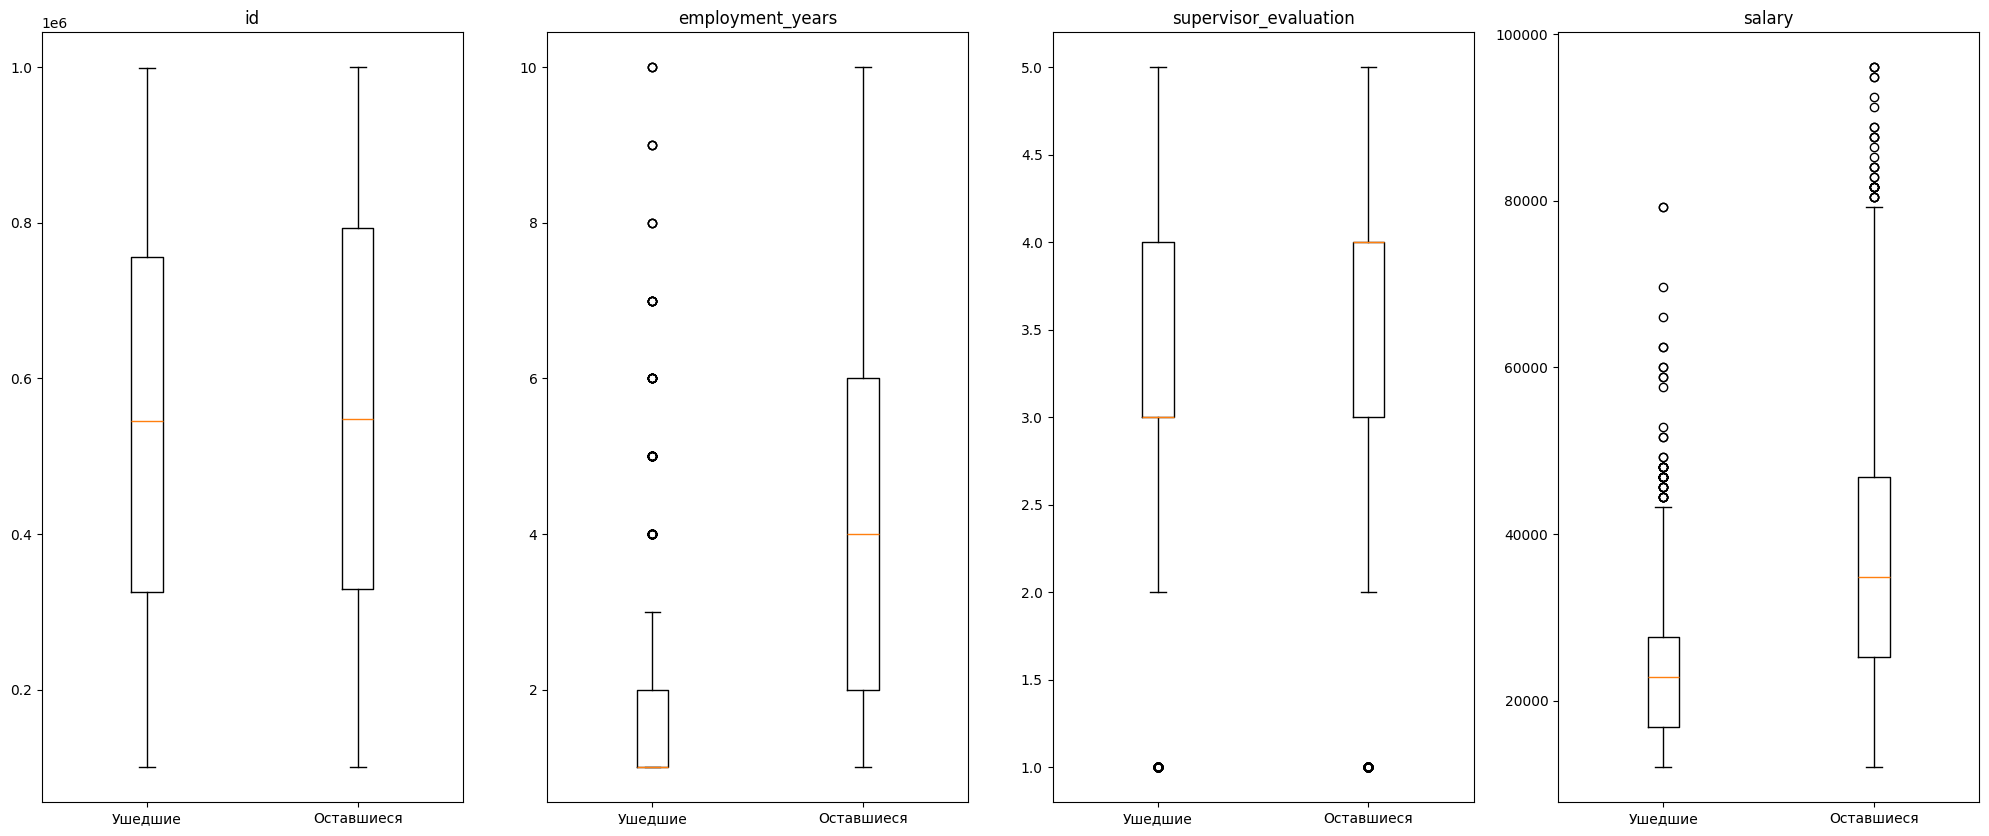

In [271]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(include='number').shape[1], figsize=(25,10))

for i, name in enumerate(df_train.select_dtypes(include='number').columns):
    axs[i].boxplot([df_train.query('quit=="yes"').loc[:, name], df_train.query('quit=="no"').loc[:, name]], labels=['Ушедшие', 'Оставшиеся'])
    axs[i].set_title(name)

plt.show()

Получаем следующие результаты:

employment_years - длительность работы у ушедших обычно меньше у ушедших, чем у оставшихся. Если люди уходят, то уходят обычно через 1-3 года, конечно, есть у ушедшие и спустя больший срок, но это выбросы.

supervisor_evaluation - Оценки, в целом, находятся наравне, но у ушедших медианное значение - 3, а у оставшихся - 4. Возможно, уходящие работали как говорится "как и все здесь", потому что уже не были заинтересованы в развитии компании.

salary - зарплата у ушедших ниже, чем средняя, так как мы видим, что люди уходят спустя 1-3 года и они не успевают выслужиться до высоких зарплат.

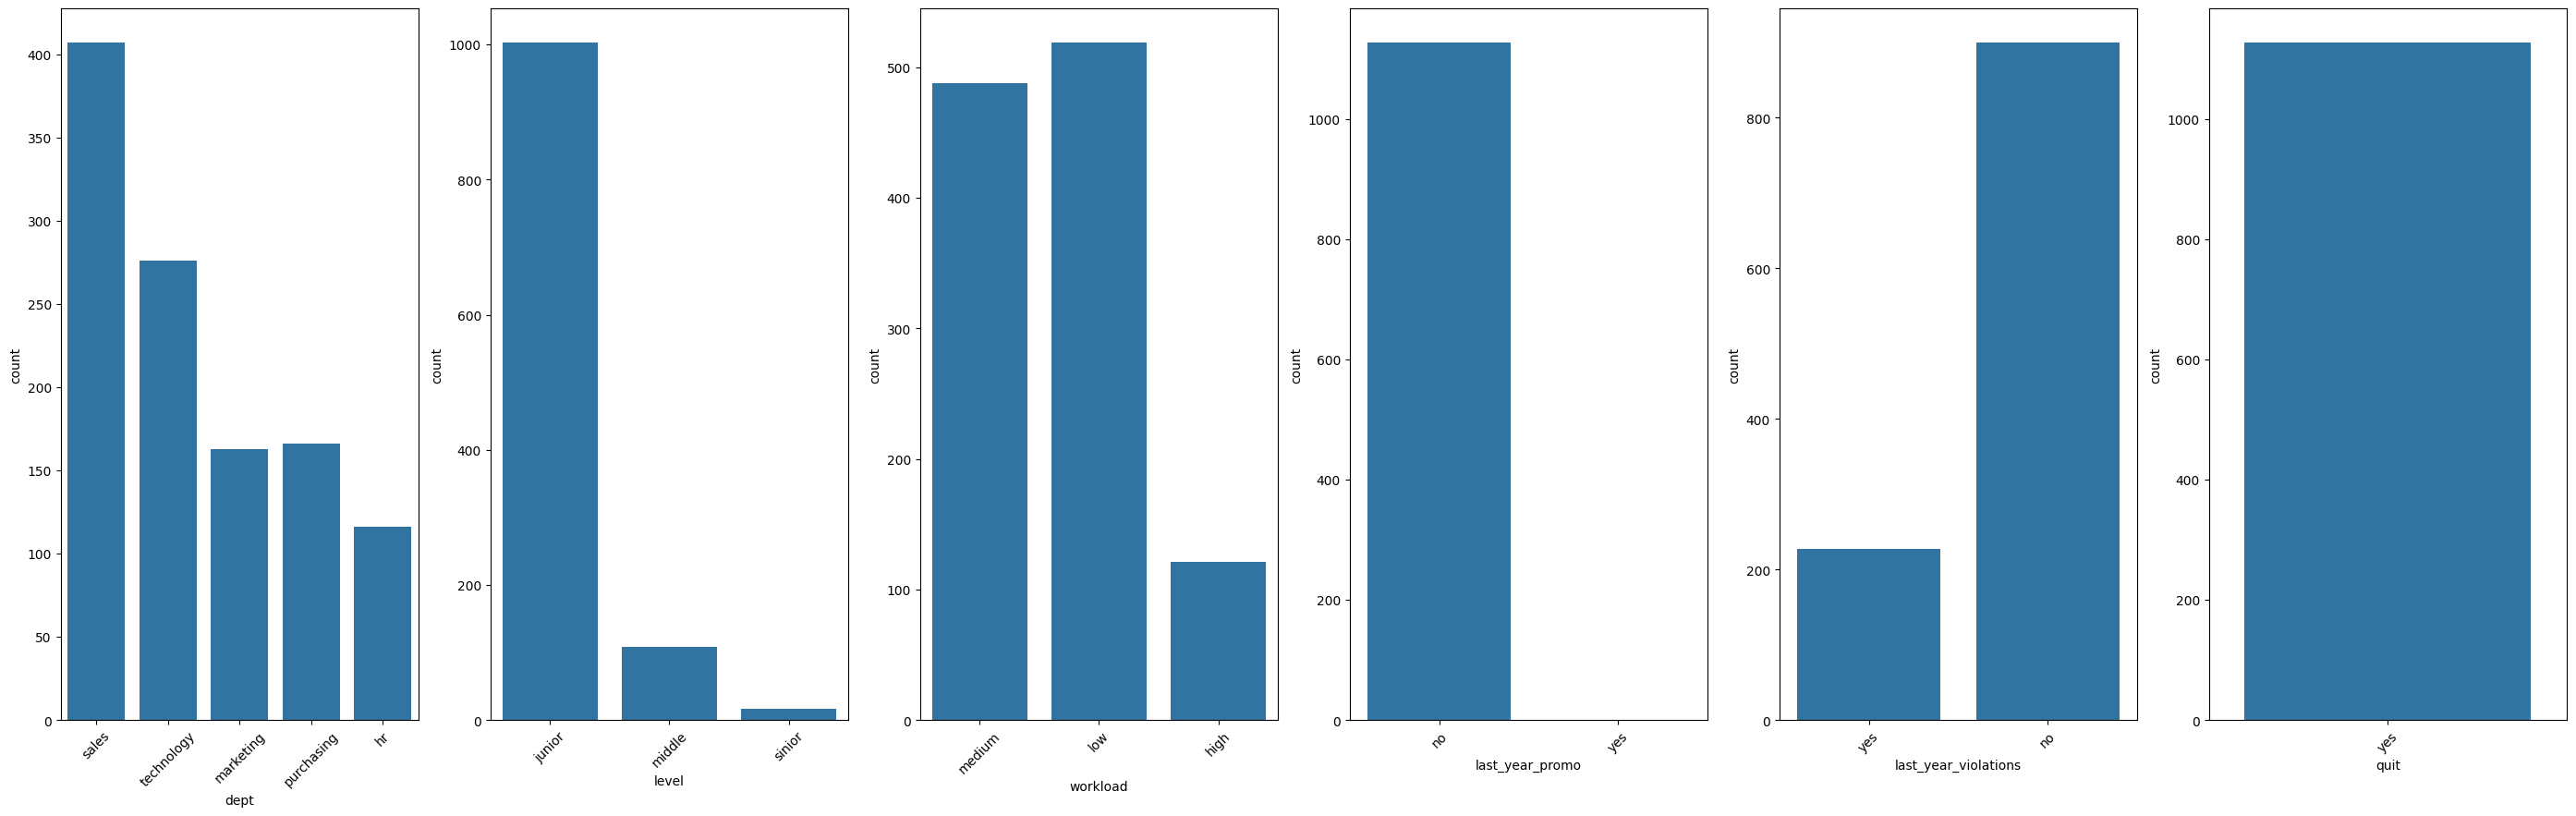

In [272]:
fig, axs = plt.subplots(nrows=1, ncols=df_train.select_dtypes(exclude='number').shape[1], figsize=(35,10))

for i, name in enumerate(df_train.select_dtypes(exclude='number').columns):
    sns.countplot(data=df_train.query('quit=="yes"'), x=name, ax=axs[i])
    axs[i].set_xlabel(name)
    axs[i].tick_params(axis='x', rotation=45)

plt.show()

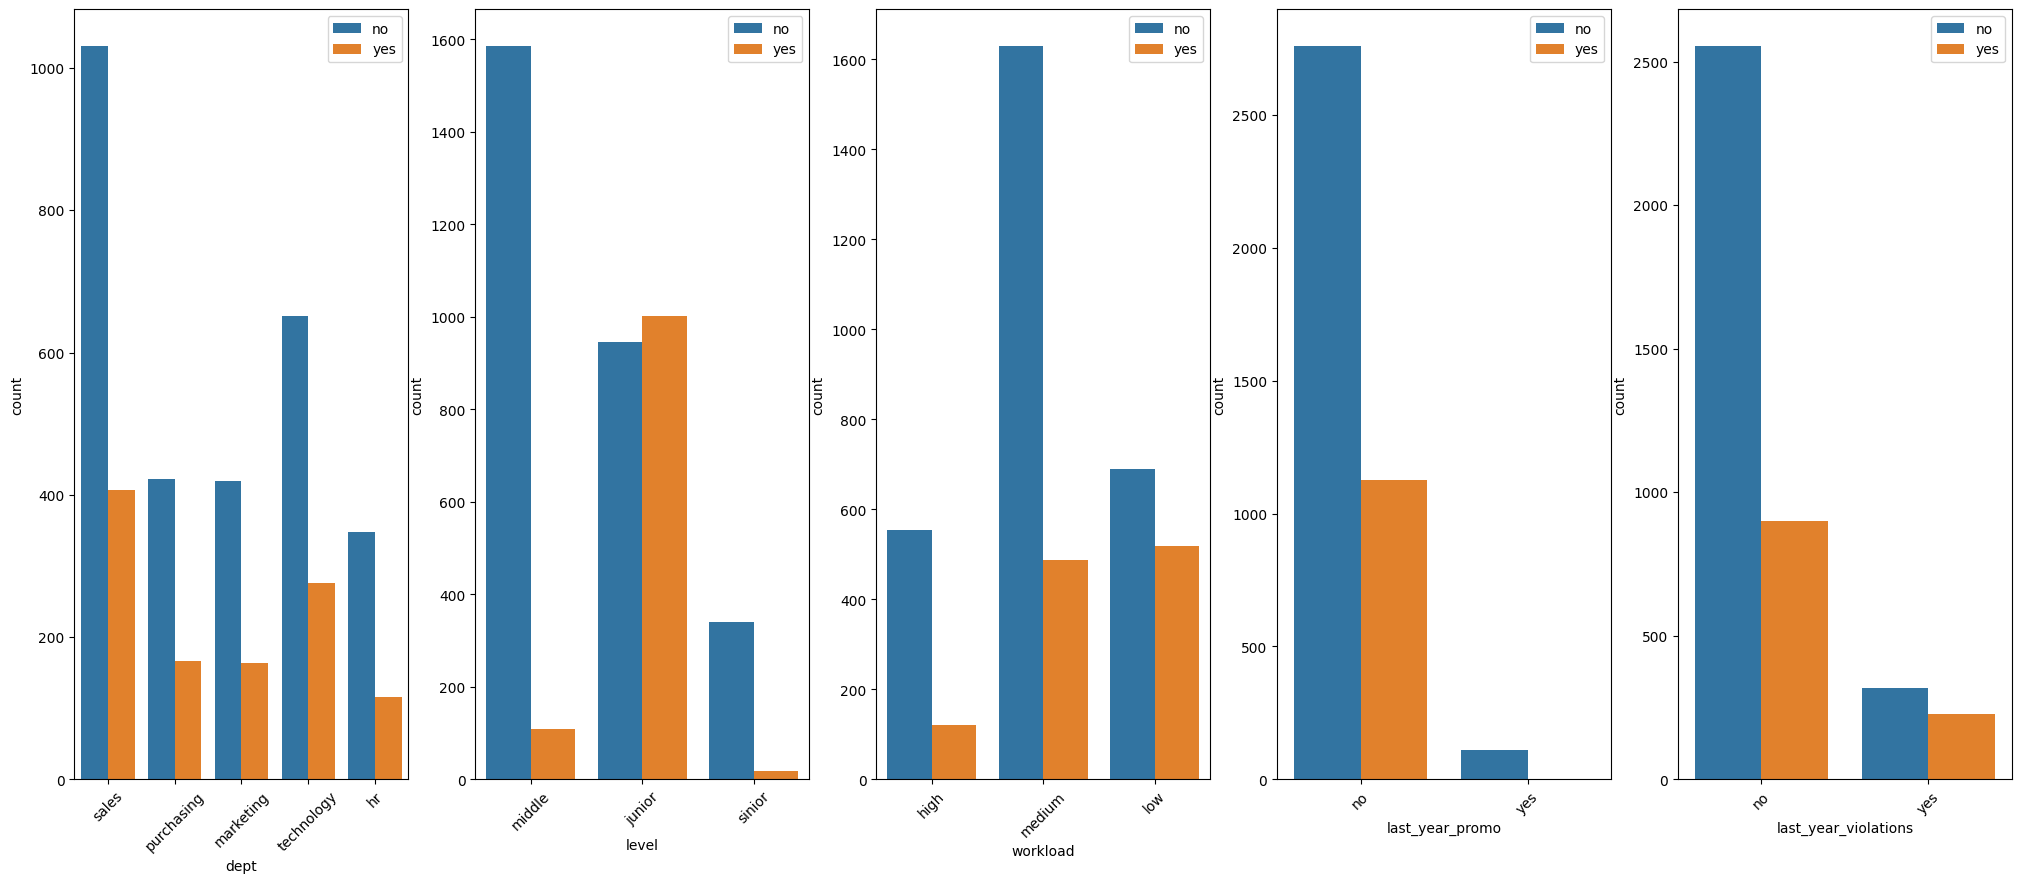

In [273]:
fig, axs = plt.subplots(nrows=1, ncols=X.select_dtypes(exclude=np.number).shape[1], figsize=(25,10))

for i, name in enumerate(X.select_dtypes(exclude=np.number).columns):
    sns.countplot(data=df_train, x=name, ax=axs[i], hue='quit')
    axs[i].set_xlabel(name)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].legend()
plt.show()

В категориальных признаках распределения ушедших и оставшихся совпадают, кроме level, видим, что больше всего уходят люди на уровне Junior, это подтверждает предположение про 1-3 года выше. Посмотрим на зависимость должности и годов работы.

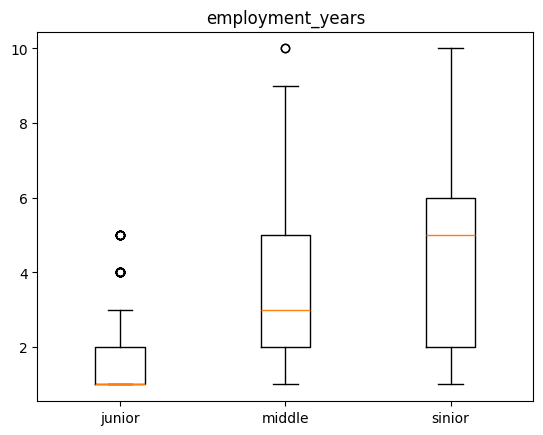

In [276]:

plt.boxplot([
    df_train.query('(level=="junior") and (quit=="yes")').loc[:, 'employment_years'], 
    df_train.query('level=="middle" and (quit=="yes")').loc[:, 'employment_years'],
    df_train.query('level=="sinior" and (quit=="yes")').loc[:, 'employment_years']], labels=['junior', 'middle', 'sinior'])
plt.title('employment_years')

plt.show()

## Корреляция job_satisfaction_rate и quit

In [78]:
df_test = df_test.merge(test_target, on='id')
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


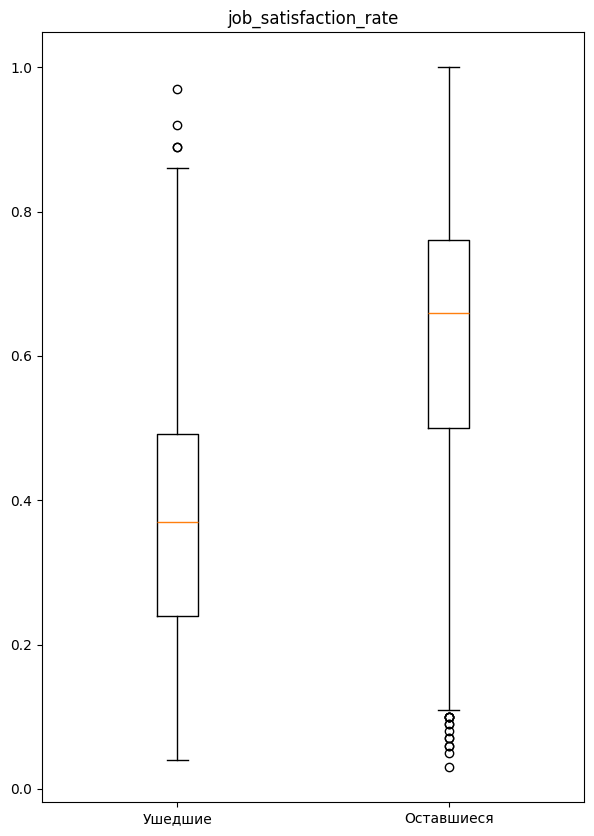

In [79]:
plt.figure(figsize=(7,10))
plt.boxplot([df_test.query('quit=="yes"').loc[:, 'job_satisfaction_rate'], df_test.query('quit=="no"').loc[:, 'job_satisfaction_rate']], labels=['Ушедшие', 'Оставшиеся'])
plt.title('job_satisfaction_rate');

Ушедшие сотрудники, действительно, меньше удовлетворены своей работой нежели остающиеся.

# Модели

In [80]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [81]:
X = df_train.copy()
X['job_satisfaction_rate'] = oscv_tree.predict(X)

In [82]:
X.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.620000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.365625
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.790000


In [83]:
y = X['quit']
X = X.drop('quit', axis=1)
num_columns += ['job_satisfaction_rate']

Воспользуемся моделями из предыдущего задания, но теперь для классификации, методы предобработки для каждой оставим те же.

## Логистическая регрессия

In [84]:
param_grid_logistic = {
    'model': CategoricalDistribution([LogisticRegression(solver='saga')]),
    'preprocessor__scaler': CategoricalDistribution([StandardScaler()]),
    'model__penalty': CategoricalDistribution(['elasticnet', 'l1', 'l2', None]),
    'model__C': FloatDistribution(0.1, 5, step=1),
    'model__l1_ratio': FloatDistribution(0.1, 1, step=1),
    'selector__k': IntDistribution(1, len(X.columns))
}

In [85]:
oscv_logistic = OptunaSearchCV(
    pipe, 
    param_grid_logistic, 
    cv=5, 
    scoring='roc_auc', 
    n_trials=35, 
    random_state=RANDOM_STATE
)

In [86]:
oscv_logistic.fit(X, y)

[I 2024-05-21 02:43:49,371] A new study created in memory with name: no-name-d733f654-118a-4f89-84ed-2ad8b11ebe1c
[I 2024-05-21 02:43:49,582] Trial 0 finished with value: 0.8603007451469011 and parameters: {'model': LogisticRegression(C=2.1, l1_ratio=0.1, penalty='l1', solver='saga'), 'preprocessor__scaler': StandardScaler(), 'model__penalty': 'l1', 'model__C': 2.1, 'model__l1_ratio': 0.1, 'selector__k': 3}. Best is trial 0 with value: 0.8603007451469011.
[I 2024-05-21 02:43:49,981] Trial 1 finished with value: 0.9173220633274942 and parameters: {'model': LogisticRegression(C=1.1, l1_ratio=0.1, penalty=None, solver='saga'), 'preprocessor__scaler': StandardScaler(), 'model__penalty': None, 'model__C': 1.1, 'model__l1_ratio': 0.1, 'selector__k': 10}. Best is trial 1 with value: 0.9173220633274942.
[I 2024-05-21 02:43:50,375] Trial 2 finished with value: 0.9172875990499783 and parameters: {'model': LogisticRegression(C=4.1, l1_ratio=0.1, penalty='elasticnet', solver='saga'), 'preprocessor

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['dept']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            Simp...
                                    'model__C': FloatDistribution(high=4.1, log=False, low=0.1, step=1.0),
                                    'model__l1_ratio': FloatDistribution(high=0.1, log=False, low=0.1, step=1.0),
                                    'model__penalty': CategoricalDistribution(choices=('elasticnet', 'l1', 'l2', None)),
                                    'preprocessor__scaler': CategoricalDistribution(choices=(StandardScaler(),)),
                                    'selector__k': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=42, scoring='roc_auc')

In [87]:
oscv_logistic.best_score_

0.9173236134267008

In [88]:
oscv_logistic.best_params_

{'model': LogisticRegression(C=1.1, l1_ratio=0.1, penalty=None, solver='saga'),
 'preprocessor__scaler': StandardScaler(),
 'model__penalty': None,
 'model__C': 0.1,
 'model__l1_ratio': 0.1,
 'selector__k': 10}

Метрика данной модели получилась хорошая, она подходит под условия >=0.91, не будем, пока проверять тестовую выборку, чтобы не подгоняться под неё. Попробуем другие модели.

## Дерево решений

In [89]:
param_grid_tree_class = {
    'model': CategoricalDistribution([DecisionTreeClassifier()]),
    'model__max_depth': IntDistribution(2, 15),
    'model__min_samples_leaf': IntDistribution(2, 15),
    'model__min_samples_split': IntDistribution(2, 15),
    'selector__k': IntDistribution(1, len(X.columns))
}

In [90]:
oscv_tree_class = OptunaSearchCV(
    pipe, 
    param_grid_tree_class, 
    cv=5, 
    scoring='roc_auc', 
    n_trials=35, 
    random_state=RANDOM_STATE
)

In [91]:
oscv_tree_class.fit(X, y)

[I 2024-05-21 02:44:00,756] A new study created in memory with name: no-name-2eaa780a-55b3-48c9-a2de-2252159e59c7
[I 2024-05-21 02:44:00,932] Trial 0 finished with value: 0.9253215279670801 and parameters: {'model': DecisionTreeClassifier(max_depth=8, min_samples_leaf=13), 'model__max_depth': 8, 'model__min_samples_leaf': 13, 'model__min_samples_split': 2, 'selector__k': 4}. Best is trial 0 with value: 0.9253215279670801.
[I 2024-05-21 02:44:01,087] Trial 1 finished with value: 0.8387877347355419 and parameters: {'model': DecisionTreeClassifier(max_depth=8, min_samples_leaf=6, min_samples_split=4), 'model__max_depth': 8, 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'selector__k': 2}. Best is trial 0 with value: 0.9253215279670801.
[I 2024-05-21 02:44:01,260] Trial 2 finished with value: 0.9191223569066398 and parameters: {'model': DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=6), 'model__max_depth': 4, 'model__min_samples_leaf': 6, 'model__mi

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['dept']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            Simp...
               param_distributions={'model': CategoricalDistribution(choices=(DecisionTreeClassifier(max_depth=7, min_samples_leaf=8, min_samples_split=13),)),
                                    'model__max_depth': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__min_samples_leaf': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__min_samples_split': IntDistribution(high=15, log=False, low=2, step=1),
                                    'selector__k': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=42, scoring='roc_auc')

In [92]:
oscv_tree_class.best_score_

0.9307774238126735

In [93]:
oscv_tree_class.best_params_

{'model': DecisionTreeClassifier(max_depth=7, min_samples_leaf=8, min_samples_split=13),
 'model__max_depth': 7,
 'model__min_samples_leaf': 8,
 'model__min_samples_split': 13,
 'selector__k': 6}

## kNN

In [94]:
param_grid_knn_class = {
    'model': CategoricalDistribution([KNeighborsClassifier()]),
    'model__n_neighbors': IntDistribution(2, 15),
    'model__metric': CategoricalDistribution(['euclidean', 'minkowski']),
    'model__weights': CategoricalDistribution(['uniform', 'distance']),
    'selector__k': IntDistribution(1, len(X.columns))
}

In [95]:
oscv_knn_class = OptunaSearchCV(
    pipe, 
    param_grid_knn_class, 
    cv=5, 
    scoring='roc_auc', 
    n_trials=35, 
    random_state=RANDOM_STATE
)

In [96]:
oscv_knn_class.fit(X, y)

[I 2024-05-21 02:44:07,399] A new study created in memory with name: no-name-bbe5ab7b-2497-4e82-a196-b465c63536a8
[I 2024-05-21 02:44:07,582] Trial 0 finished with value: 0.8516223498928479 and parameters: {'model': KNeighborsClassifier(metric='euclidean', n_neighbors=8, weights='distance'), 'model__n_neighbors': 8, 'model__metric': 'euclidean', 'model__weights': 'distance', 'selector__k': 3}. Best is trial 0 with value: 0.8516223498928479.
[I 2024-05-21 02:44:07,779] Trial 1 finished with value: 0.6779347323617729 and parameters: {'model': KNeighborsClassifier(n_neighbors=4, weights='distance'), 'model__n_neighbors': 4, 'model__metric': 'minkowski', 'model__weights': 'distance', 'selector__k': 10}. Best is trial 0 with value: 0.8516223498928479.
[I 2024-05-21 02:44:07,979] Trial 2 finished with value: 0.7175528599552258 and parameters: {'model': KNeighborsClassifier(n_neighbors=9, weights='distance'), 'model__n_neighbors': 9, 'model__metric': 'minkowski', 'model__weights': 'distance',

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           Pipeline(steps=[('simpleImputer_ohe',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='ignore',
                                                                                                          sparse_output=False))]),
                                                                           ['dept']),
                                                                          ('ord',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            Simp...
               param_distributions={'model': CategoricalDistribution(choices=(KNeighborsClassifier(n_neighbors=10, weights='distance'),)),
                                    'model__metric': CategoricalDistribution(choices=('euclidean', 'minkowski')),
                                    'model__n_neighbors': IntDistribution(high=15, log=False, low=2, step=1),
                                    'model__weights': CategoricalDistribution(choices=('uniform', 'distance')),
                                    'selector__k': IntDistribution(high=10, log=False, low=1, step=1)},
               random_state=42, scoring='roc_auc')

In [97]:
oscv_knn_class.best_score_

0.9181567996941784

In [98]:
oscv_knn_class.best_params_

{'model': KNeighborsClassifier(n_neighbors=10, weights='distance'),
 'model__n_neighbors': 12,
 'model__metric': 'minkowski',
 'model__weights': 'uniform',
 'selector__k': 8}

## Выводы

Лучше всех опять же вышло дерево решений, посмотрим её метрики на тестовой выборке. Эта модель один из признаков, имеет следующие гиперпараметры: max_depth=12, min_samples_leaf=15, min_samples_split=15. За pos_label возьмём quit = yes.

In [99]:
df_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [100]:
X_test = df_test.drop('quit', axis=1)
y_test = df_test['quit']
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


Precision 0.8915441176470589
Recall 0.8599290780141844
F1 0.8754512635379061
ROC-AUC =  0.93


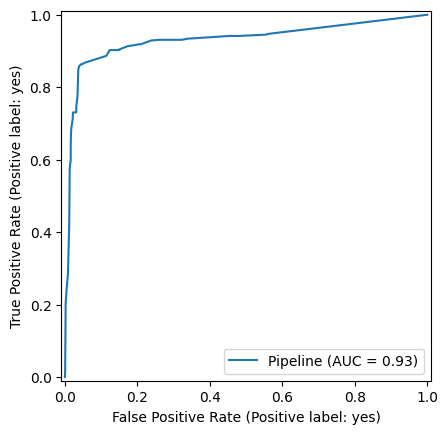

In [101]:
pred_probas = oscv_tree_class.predict_proba(X_test)
preds = oscv_tree_class.predict(X_test)

roc_auc = roc_auc_score(y_test, pred_probas[:, 1])
print('Precision', precision_score(y_test, preds, pos_label='yes'))
print('Recall', recall_score(y_test, preds, pos_label='yes'))
print('F1', f1_score(y_test, preds, pos_label='yes'))
print('ROC-AUC = ', roc_auc.round(2))

RocCurveDisplay.from_estimator(oscv_tree_class.best_estimator_, X_test, y_test);

Метрика получилась подходящей, возьмём эту модель, так как она подходит под ROC-AUC и отрабатывает лучше всех остальных моделей.

# Общие выводы

## Задание

У нас имелись данные о сотрудниках, полученные путем некоторого тестирования. HR-аналаитики компании "Работа с заботой" хотят оптимизировать управление персоналом. Они поставили перед нами задачу создать две модели: одна для предсказания уровня удовлетворенности сотрудников компание - от 0 до 1 и вторая для предсказания ухода сотрудника из компании.

## Этапы работы

Сначала были загружены данные для создания модели регрессии, имелось 3 файла, один с тренировочной, второй с тестовой и третий с целевым признаком для тестовой выборки. Данные были изучены. Затем был создан пайплайн для предобработки данных. Пайплайн был использован для обучения моделей. Были обучены 3 модели: линейная регрессия, дерево решений и kNN. По кастомной метрике smape, лучше всего показало себя дерево решений с такими гиперпараметрами: max_depth=13, min_samples_leaf=6, min_samples_split=4, k для SelectKBest равно 9. Метрика SMAPE этой модели для тренировочной выборки вышла 14.38, а r2 = 0.86.

Затем была решена задача классификации, у неё были точно такие же этапы и были использованы те же виды моделей, но для классификации, лучшим опять вышло дерево решений с гиперпараметрами: max_depth=6, min_samples_leaf=7, min_samples_split=6 и SelectKBest оставил 6 признаков.

## Рекомендации



По задаче удержания работников можно дать рекомендацию, чтобы компания старалась удерживать сотрудников больше, чем на 1-3 года, потому что в большинстве своём уходят именно такие. По диаграмме видно, люди переходят на позицию middle как раз через 3 года. Возможно, стоит попробовать сделать более понятные алгоритмы повышения, чтобы люди оставались работать.